In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn
from pandas.api.types import CategoricalDtype
import IPython.display as ipd
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import random
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 150

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [4]:
df['target']=[1 if genre == 'Rock' else 0 for genre in df['TRACK_genre_top']]

<AxesSubplot:>

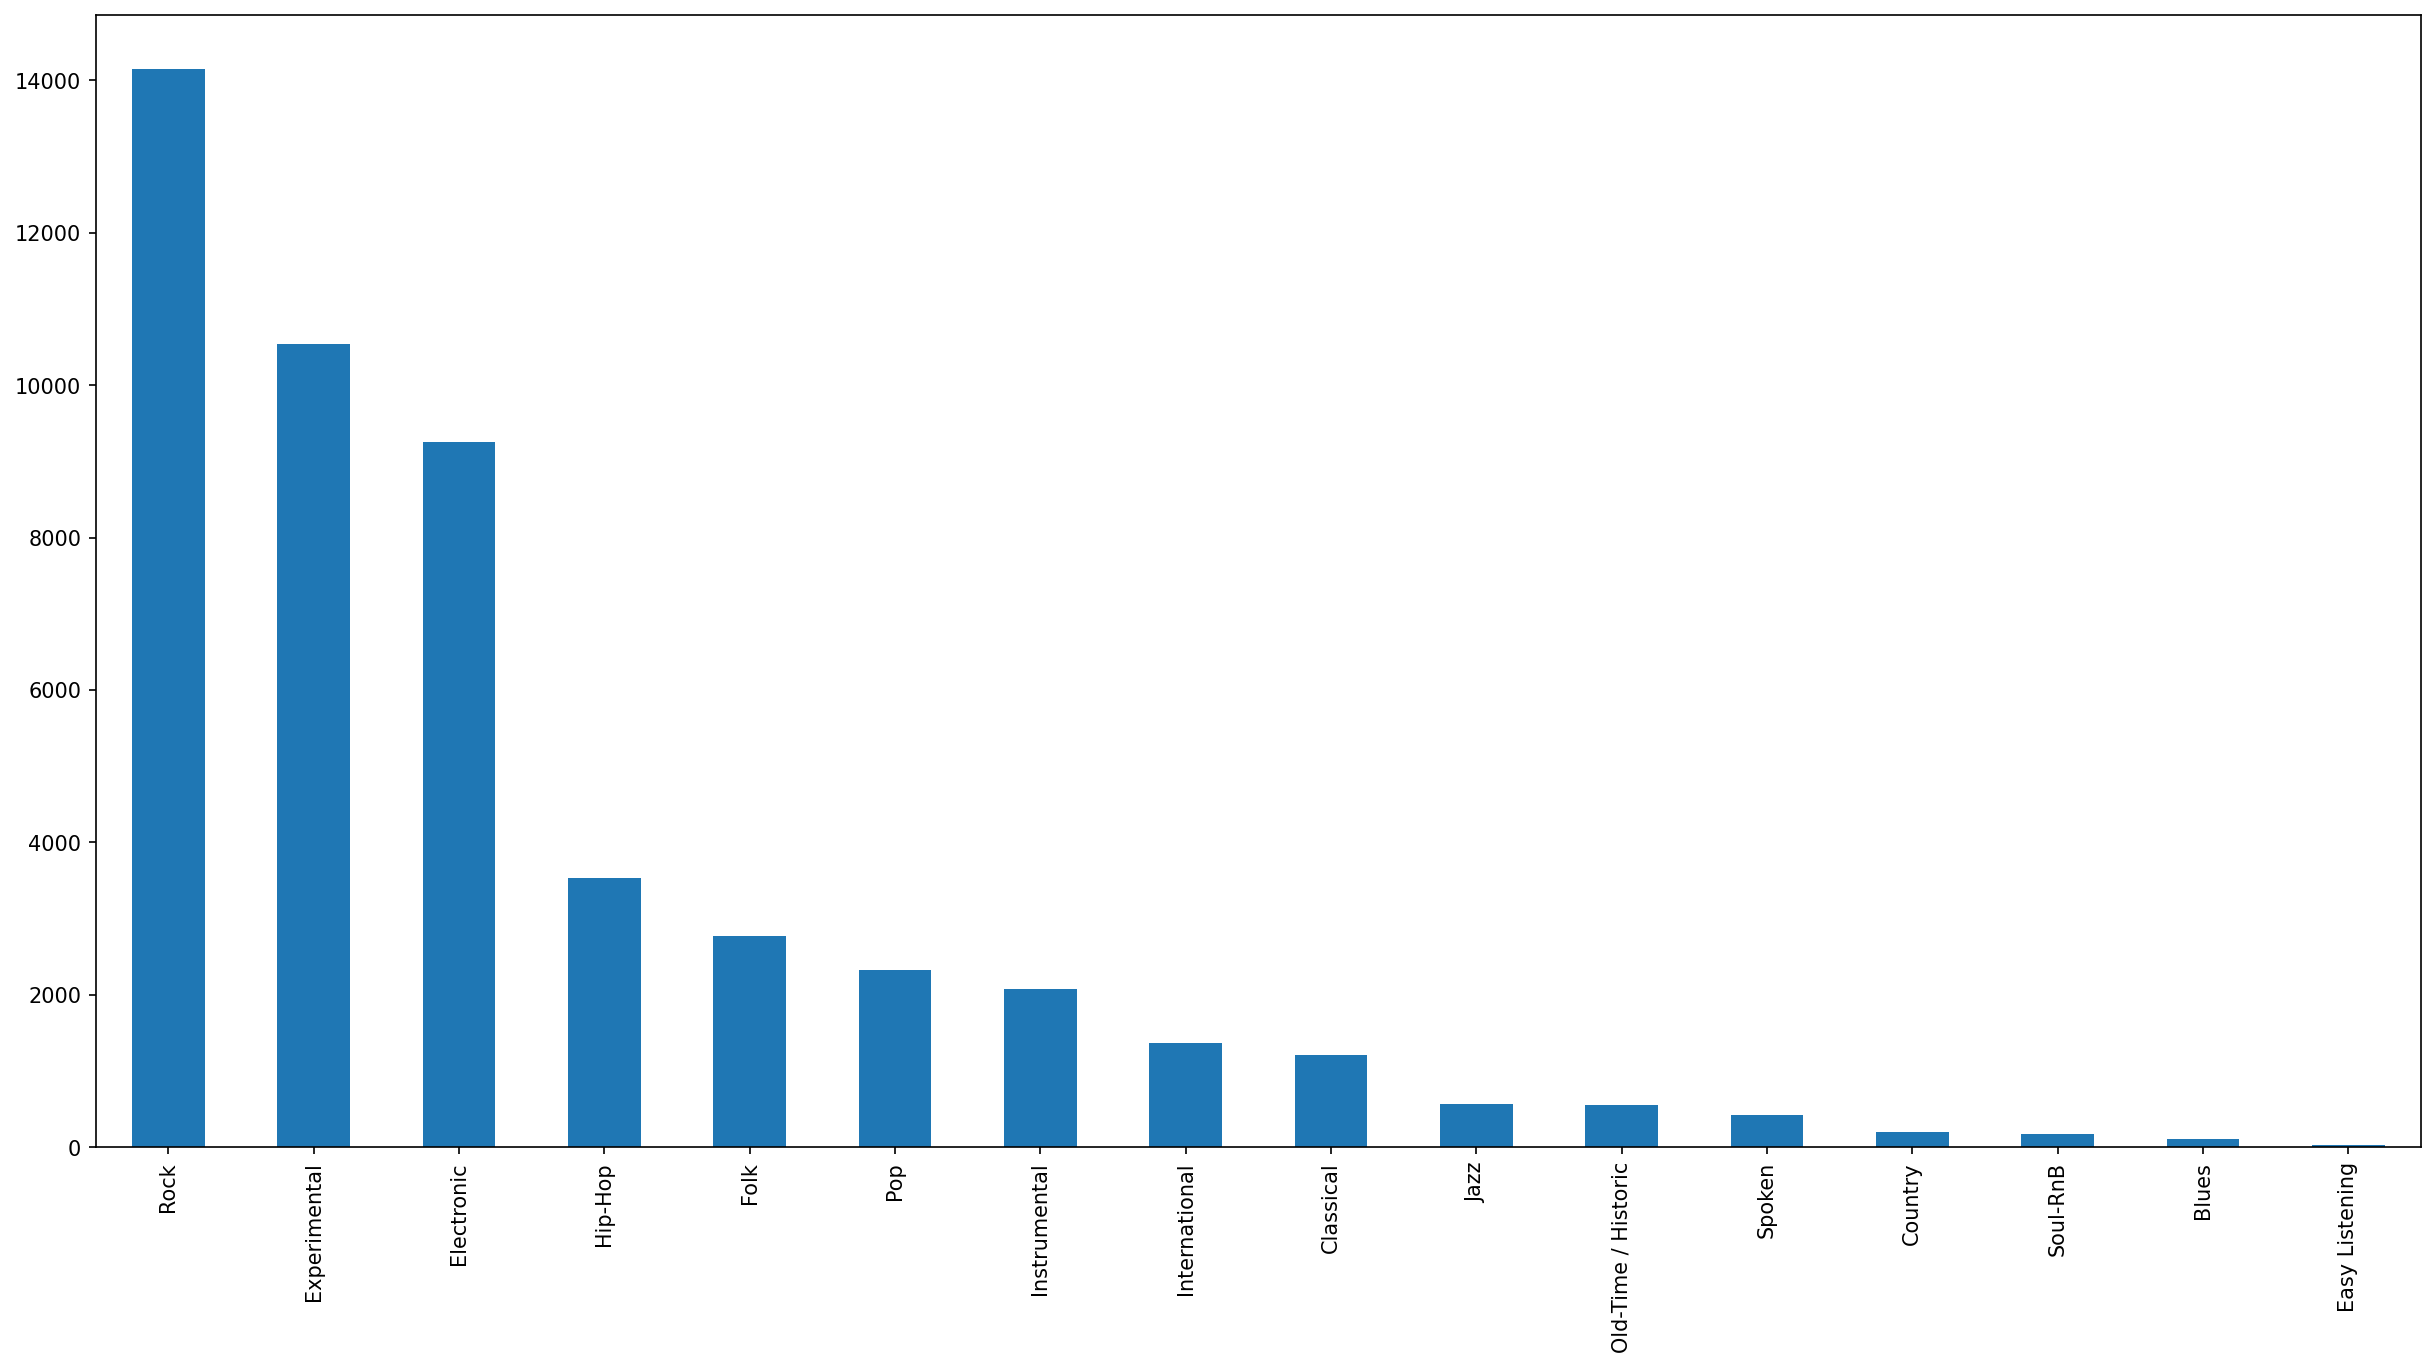

In [5]:
df.TRACK_genre_top.value_counts().plot(kind='bar')

In [6]:
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli

In [7]:
label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df['TRACK_genre_top_num'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df['TRACK_genre_top_num']]



df['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df['TRACK_genre_top_num']]


df['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df['TRACK_genre_top_num']] #rock 13 --> 3
df['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df['TRACK_genre_top_num']] #pop 12 --> 2

<AxesSubplot:>

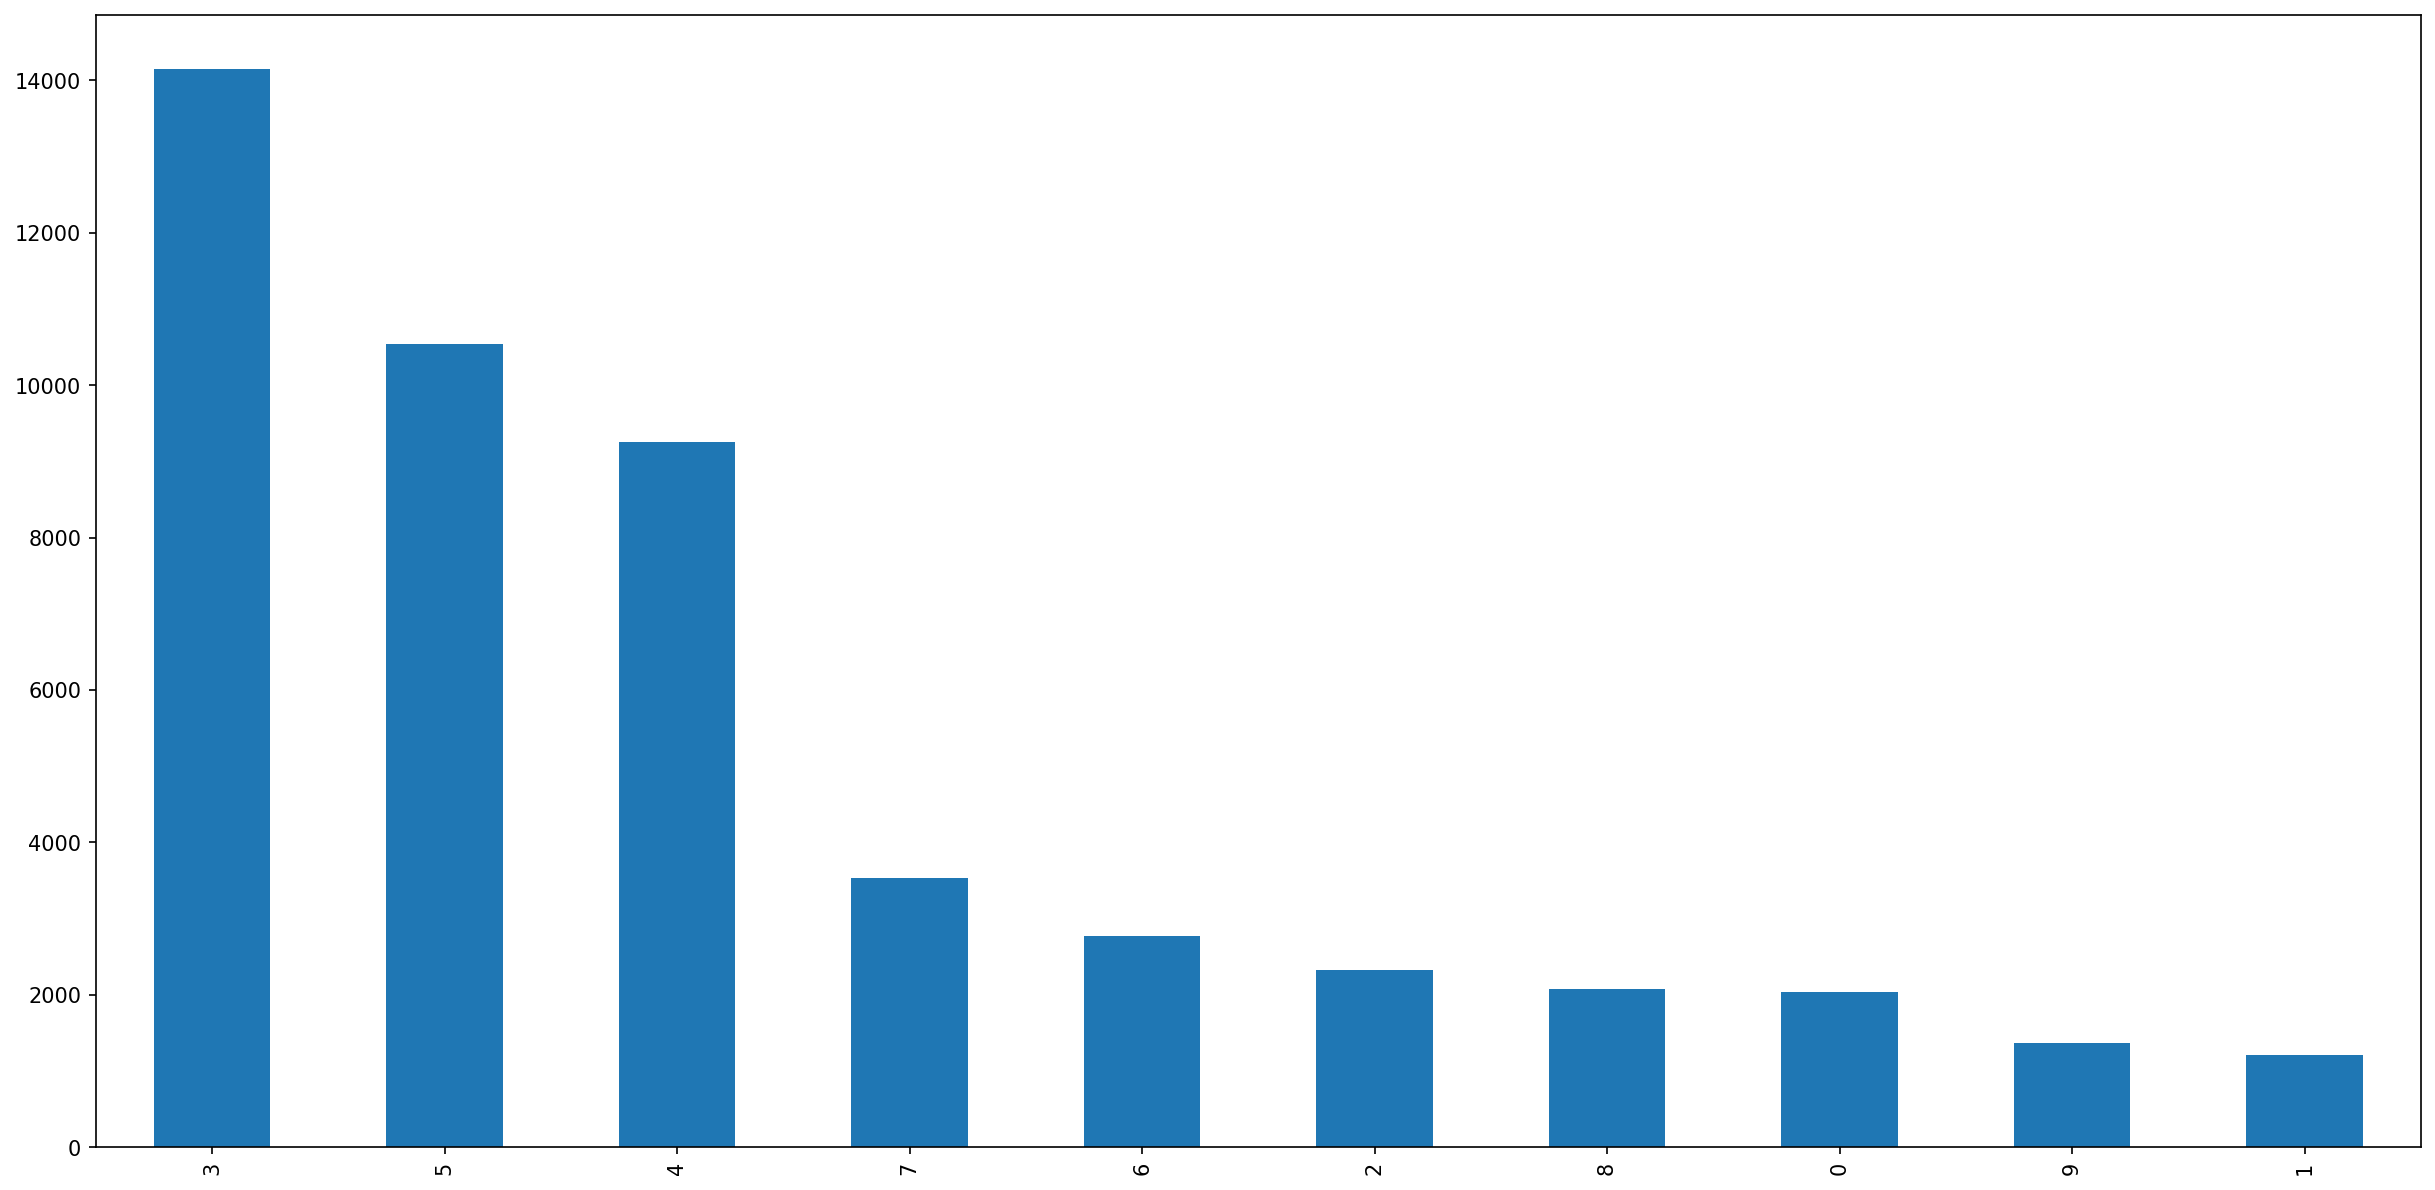

In [9]:
df.TRACK_genre_top_num.value_counts().plot(kind='bar')

In [10]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

In [11]:
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'] + ['TRACK_genre_top_num'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

# Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [13]:
#Rimozione features correlate tra loro
attributes = compl + features
corrMatrix = df[attributes].corr()
m = ~(corrMatrix.mask(np.eye(len(corrMatrix), dtype=bool)).abs() > 0.50).any()
m

ALBUM_date_released_year_     True
ALBUM_favorites_             False
ALBUM_listens_               False
ALBUM_tracks_                False
ALBUM_type_                   True
                             ...  
zcrmean01                    False
zcrmedian01                  False
zcrmin01                     False
zcrskew01                    False
zcrstd01                     False
Length: 88, dtype: bool

In [14]:
df[m.index[m]]

,ALBUM_date_released_year_,ALBUM_type_,ARTIST_favorites_,TRACK_bitrate,TRACK_duration,chroma_cqtmax,chroma_stftmax,chroma_stftmin,spectral_contrastkurtosis,spectral_contrastmax,spectral_contrastmin,tonnetzkurtosis,tonnetzskew,rmsekurtosis01,rmsemin01
track_id,,,,,,,,,,,,,,,
2,2009.0,0,9.0,256000,168,-0.002102,-0.000779,-0.016616,1.668064,-2.545115,-1.293357,1.335255,-0.152102,2.499856,0.000000
3,2009.0,0,9.0,256000,237,-0.002102,-0.000779,-0.016616,1.434687,-0.213987,-13.469220,0.087193,-0.251621,-0.643963,0.000000
5,2009.0,0,9.0,256000,206,-0.002102,-0.000779,-0.016616,-1.465540,-7.390662,-0.652101,3.707580,-0.209312,0.001781,0.000000
10,2008.0,0,74.0,192000,161,-0.002102,-0.000779,-0.016616,-2.544758,-0.052706,2.498103,1.841458,-0.360596,1.766149,0.000000
134,2009.0,0,9.0,256000,207,-0.002102,-0.000779,-0.016616,-1.754028,-2.917778,-2.250054,6.580380,-1.213183,2.133233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155315,2017.0,2,0.0,320000,38,-0.002102,-0.000779,-0.006141,-3.466109,-11.280662,6.202620,-1.260438,0.618452,-0.265316,0.000134
155316,2017.0,2,0.0,320000,162,-0.002102,-0.000779,0.016372,-1.763240,-6.637459,3.519979,-0.902569,0.233260,1.181682,0.000113
155317,2017.0,2,0.0,320000,217,-0.002102,-0.000779,-0.012925,-3.236400,-3.509738,0.433066,-1.008135,-0.439485,4.631377,0.000840


In [15]:
class_name = 'TRACK_genre_top_num'

#attributes = compl+features
#X = df[attributes].values
X = df[m.index[m]].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [16]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [17]:
y_pred = clf.predict(X_test)

In [18]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.28776297098017994
F1-score [0.0390516  0.06342495 0.02227723 0.49125349 0.16107737 0.27680038
 0.0220022  0.21405139 0.29359823 0.06060606]
              precision    recall  f1-score   support

           0       0.13      0.02      0.04       611
           1       0.14      0.04      0.06       364
           2       0.08      0.01      0.02       697
           3       0.44      0.56      0.49      4247
           4       0.30      0.11      0.16      2778
           5       0.54      0.19      0.28      3163
           6       0.13      0.01      0.02       832
           7       0.13      0.74      0.21      1061
           8       0.47      0.21      0.29       621
           9       0.07      0.05      0.06       409

    accuracy                           0.29     14783
   macro avg       0.24      0.20      0.16     14783
weighted avg       0.35      0.29      0.27     14783



# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
class_name = 'TRACK_genre_top_num'

attributes  = Diff(compl + features, ['TRACK_genre_top_num']) 
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [21]:
clf = LogisticRegression(random_state=0, max_iter=10000, class_weight='balanced') ## con il peso meglio f1, ma peggio accuracy
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=0)

In [22]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4346884935398769
F1-score [0.28571429 0.43714051 0.13636364 0.69123284 0.43452125 0.31235098
 0.31324346 0.41953663 0.2745098  0.19006479]
              precision    recall  f1-score   support

           0       0.27      0.31      0.29       611
           1       0.31      0.73      0.44       364
           2       0.14      0.14      0.14       697
           3       0.73      0.66      0.69      4247
           4       0.54      0.36      0.43      2778
           5       0.64      0.21      0.31      3163
           6       0.23      0.47      0.31       832
           7       0.31      0.63      0.42      1061
           8       0.23      0.35      0.27       621
           9       0.13      0.32      0.19       409

    accuracy                           0.43     14783
   macro avg       0.35      0.42      0.35     14783
weighted avg       0.52      0.43      0.44     14783



# RIPPER

In [22]:
import wittgenstein as lw

In [30]:
class_name = 'TRACK_genre_top_num'

attributes = compl + features
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [31]:
from keras.utils.np_utils import to_categorical   

y_train_ = to_categorical(y_train, num_classes=10)
y_test_ = to_categorical(y_test, num_classes=10)

In [32]:
y_train = y_train_[:,1]
y_test = y_test_[:,1]

In [33]:
ripper_clf = lw.RIPPER(verbosity=5)
ripper_clf.fit(X_train, y_train, pos_class=1)
ripper_clf


0: fitting 56 unique vals into 10 bins
bin #0, floor idx 0 value: 1905.0, ceiling idx 3644 value: 2008.0
bin #1, floor idx 3645 value: 2008.0, ceiling idx 9773 value: 2010.0
bin #2, floor idx 9774 value: 2010.0, ceiling idx 16228 value: 2010.5
bin #3, floor idx 16229 value: 2010.5, ceiling idx 21681 value: 2013.0
bin #4, floor idx 21682 value: 2013.0, ceiling idx 28671 value: 2014.0
bin #5, floor idx 28672 value: 2014.0, ceiling idx 32649 value: 2016.0
bin #6, floor idx 32650 value: 2016.0, ceiling idx 34491 value: 2021.0
-bin sizes [3644, 6128, 6454, 5452, 6989, 3977, 1841]; dataVMR=0.01, binVMR=591
1: fitting 114 unique vals into 10 bins
bin #0, floor idx 0 value: 0.0, ceiling idx 15150 value: 0.6931471805599453
bin #1, floor idx 15151 value: 0.6931471805599453, ceiling idx 22960 value: 1.0986122886681098
bin #2, floor idx 22961 value: 1.0986122886681098, ceiling idx 26911 value: 1.3862943611198906
bin #3, floor idx 26912 value: 1.3862943611198906, ceiling idx 30453 value: 1.7917594

bin #0, floor idx 0 value: -0.028039777975236675, ceiling idx 15508 value: -0.02802977205285475
bin #1, floor idx 15509 value: -0.028029164825083167, ceiling idx 18959 value: -0.02592199675895621
bin #2, floor idx 18960 value: -0.025918524996139117, ceiling idx 22410 value: -0.01825714924069449
bin #3, floor idx 22411 value: -0.018256803466748045, ceiling idx 25861 value: -0.0016007862103931722
bin #4, floor idx 25862 value: -0.0015909871962211026, ceiling idx 29312 value: 0.03436209766010217
bin #5, floor idx 29313 value: 0.034365401096133334, ceiling idx 32763 value: 0.1388251894325369
bin #6, floor idx 32764 value: 0.13883524941234487, ceiling idx 34491 value: 0.7786810916474451
-bin sizes [15508, 3450, 3450, 3450, 3450, 3450, 1727]; dataVMR=1.6, binVMR=3860
16: fitting 34205 unique vals into 10 bins
bin #0, floor idx 0 value: -8.908167732512231, ceiling idx 3450 value: -0.9466201922358042
bin #1, floor idx 3451 value: -0.9465010384545084, ceiling idx 6901 value: -0.6254269831848303

bin #0, floor idx 0 value: -0.0007793045155414665, ceiling idx 34091 value: -0.0007266015090641109
bin #1, floor idx 34092 value: -0.0007173834858357492, ceiling idx 34491 value: 1.1104428296853768
-bin sizes [34091, 399]; dataVMR=-1.74, binVMR=16456
27: fitting 34205 unique vals into 10 bins
bin #0, floor idx 0 value: -1.3891980745751784, ceiling idx 3450 value: -0.41342265875119777
bin #1, floor idx 3451 value: -0.4133989794679007, ceiling idx 6902 value: -0.276284779351653
bin #2, floor idx 6903 value: -0.2762037096849395, ceiling idx 10353 value: -0.18043033338916376
bin #3, floor idx 10354 value: -0.18038510238888705, ceiling idx 13804 value: -0.0986818489481632
bin #4, floor idx 13805 value: -0.09867826354179687, ceiling idx 17255 value: -0.023188343460902032
bin #5, floor idx 17256 value: -0.023152459332211075, ceiling idx 20706 value: 0.05238081053390077
bin #6, floor idx 20707 value: 0.05244018391564527, ceiling idx 24157 value: 0.13635758132752654
bin #7, floor idx 24158 valu

-bin sizes [3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3432]; dataVMR=-979.3, binVMR=0.01
35: fitting 34205 unique vals into 10 bins
bin #0, floor idx 0 value: -343.4683250262744, ceiling idx 3450 value: -136.63020279291948
bin #1, floor idx 3451 value: -136.60826196087157, ceiling idx 6901 value: -102.84833675700487
bin #2, floor idx 6902 value: -102.84555493752528, ceiling idx 10352 value: -75.25005162329623
bin #3, floor idx 10353 value: -75.25005162329623, ceiling idx 13803 value: -49.890706537981615
bin #4, floor idx 13804 value: -49.88871029207265, ceiling idx 17254 value: -24.37343314342675
bin #5, floor idx 17255 value: -24.36085266407282, ceiling idx 20705 value: 3.7724076579779138
bin #6, floor idx 20706 value: 3.7727437622328375, ceiling idx 24156 value: 37.13041458143372
bin #7, floor idx 24157 value: 37.13043153093171, ceiling idx 27607 value: 77.81590212561878
bin #8, floor idx 27608 value: 77.82117708562784, ceiling idx 31058 value: 134.6882177076183
bin #9, f

46: fitting 34205 unique vals into 10 bins
bin #0, floor idx 0 value: -4.486978501754751, ceiling idx 3450 value: -2.3385904999582308
bin #1, floor idx 3451 value: -2.3384870549292325, ceiling idx 6901 value: -2.02594557648407
bin #2, floor idx 6902 value: -2.0257851380460448, ceiling idx 10352 value: -1.7587021653052708
bin #3, floor idx 10353 value: -1.7586248727215776, ceiling idx 13803 value: -1.490124155616745
bin #4, floor idx 13804 value: -1.4899671190665509, ceiling idx 17254 value: -1.1775704234077595
bin #5, floor idx 17255 value: -1.1775037580711112, ceiling idx 20705 value: -0.7944303352576544
bin #6, floor idx 20706 value: -0.7942491691123449, ceiling idx 24157 value: -0.2703660850029904
bin #7, floor idx 24158 value: -0.2703370669434034, ceiling idx 27608 value: 0.5247510424147451
bin #8, floor idx 27609 value: 0.5253646514748119, ceiling idx 31059 value: 2.4086578606195737
bin #9, floor idx 31060 value: 2.413381887686934, ceiling idx 34491 value: 167.26041752645554
-bin 

-bin sizes [3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3432]; dataVMR=1.8, binVMR=0.01
57: fitting 21465 unique vals into 10 bins
bin #0, floor idx 0 value: 0.0, ceiling idx 12606 value: 3.5905382834e-11
bin #1, floor idx 12607 value: 3.5905382834e-11, ceiling idx 16057 value: 2.0908222723e-05
bin #2, floor idx 16058 value: 2.0927658625e-05, ceiling idx 19508 value: 6.883763126100001e-05
bin #3, floor idx 19509 value: 6.884040340100001e-05, ceiling idx 22959 value: 0.00011673740664000001
bin #4, floor idx 22960 value: 0.00011676074064, ceiling idx 26410 value: 0.00038307358045
bin #5, floor idx 26411 value: 0.00038329014205, ceiling idx 29861 value: 0.0011687334627
bin #6, floor idx 29862 value: 0.0011692054104000002, ceiling idx 33312 value: 0.030160542577999997
bin #7, floor idx 33313 value: 0.030229544267000006, ceiling idx 34491 value: 12.921484947
-bin sizes [12606, 3450, 3450, 3450, 3450, 3450, 3450, 1178]; dataVMR=3.8, binVMR=2409
58: fitting 34196 unique vals into 10

-bin sizes [3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3450, 3432]; dataVMR=228, binVMR=0.01
70: fitting 34180 unique vals into 10 bins
bin #0, floor idx 0 value: 0.0, ceiling idx 3450 value: 511.40588379
bin #1, floor idx 3451 value: 511.46005249, ceiling idx 6901 value: 674.65338135
bin #2, floor idx 6902 value: 674.72711182, ceiling idx 10352 value: 808.01849365
bin #3, floor idx 10353 value: 808.05114746, ceiling idx 13803 value: 930.41357422
bin #4, floor idx 13804 value: 930.46569824, ceiling idx 17254 value: 1048.401123
bin #5, floor idx 17255 value: 1048.4216309, ceiling idx 20705 value: 1166.0256348
bin #6, floor idx 20706 value: 1166.0300293, ceiling idx 24156 value: 1297.3774414000004
bin #7, floor idx 24157 value: 1297.3778075999999, ceiling idx 27607 value: 1472.9638672
bin #8, floor idx 27608 value: 1473.0456543, ceiling idx 31058 value: 1757.8685303
bin #9, floor idx 31059 value: 1757.9609375, ceiling idx 34491 value: 7193.0854492
-bin sizes [3450, 3450, 3450, 3450,

-bin sizes [12606, 4175, 3510, 3761, 3475, 3529, 3429]; dataVMR=705, binVMR=2007
79: fitting 34192 unique vals into 10 bins
bin #0, floor idx 0 value: -48.112983703999994, ceiling idx 3450 value: -0.08592575043400001
bin #1, floor idx 3451 value: -0.08586600422900001, ceiling idx 6901 value: 0.3117506206
bin #2, floor idx 6902 value: 0.31177276373, ceiling idx 10352 value: 0.60623759031
bin #3, floor idx 10353 value: 0.60623842478, ceiling idx 13803 value: 0.8840587735200002
bin #4, floor idx 13804 value: 0.88413500786, ceiling idx 17254 value: 1.1792253256
bin #5, floor idx 17255 value: 1.179259181, ceiling idx 20705 value: 1.5240310431
bin #6, floor idx 20706 value: 1.5240710974, ceiling idx 24156 value: 2.0380871296
bin #7, floor idx 24157 value: 2.0383491516, ceiling idx 27607 value: 2.8359827995
bin #8, floor idx 27608 value: 2.8368663788, ceiling idx 31058 value: 4.5868964194999995
bin #9, floor idx 31059 value: 4.5871706008999995, ceiling idx 34491 value: 62.733852386
-bin sizes

growing ruleset...

pos_growset 568 pos_pruneset 280
neg_growset 22541 neg_pruneset 11103
growing rule from initial rule: [True]
gain 1191 33=111.12-924.15
negs remaining: 1864
gain 340 52=0.06-0.22
negs remaining: 369
gain 112 82=0.02-0.17
negs remaining: 81
gain 59.9 5=9.0-15.0
negs remaining: 5
gain 6.5 36=64.89-609.7
negs remaining: 0
grew rule: [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7]
prune value of [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7]: 1
prune value of [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0]: 0.94
prune value of [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17]: 0.33
prune value of [33=111.12-924.15^52=0.06-0.22]: -0.13
prune value of [33=111.12-924.15]: -0.65
pruned rule unchanged
updated ruleset: [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7]

rule theory bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=

gain 609 33=111.12-924.15
negs remaining: 1893
gain 153 11=-4.52--2.26
negs remaining: 283
gain 50.1 30=1.73-98.79
negs remaining: 123
gain 30 55=0.0-1.53
negs remaining: 36
gain 14 65=2.93-44.11
negs remaining: 7
gain 4.7 84=0.02-0.02
negs remaining: 0
grew rule: [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53^65=2.93-44.11^84=0.02-0.02]
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53^65=2.93-44.11^84=0.02-0.02]: 0.43
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53^65=2.93-44.11]: 0.17
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53]: -0.1
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79]: -0.19
prune value of [33=111.12-924.15^11=-4.52--2.26]: -0.51
prune value of [33=111.12-924.15]: -0.78
pruned rule unchanged
updated ruleset: ...[33=111.12-924.15^52=0.06-0.22^5=15.0-30.0^59=0.0-0.92^87=0.0-0.02] V [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53^65=2.93-44.11^84=0.02-0.02

gain 387 33=111.12-924.15
negs remaining: 1856
gain 75.8 15=-0.03--0.03
negs remaining: 1037
gain 54.8 11=-4.52--2.26
negs remaining: 225
gain 30.5 30=1.73-98.79
negs remaining: 94
gain 18.7 59=0.0-0.92
negs remaining: 24
gain 8.2 0=2009.0-2010.0
negs remaining: 2
gain 1.7 12=-0.5--0.23
negs remaining: 0
grew rule: [33=111.12-924.15^15=-0.03--0.03^11=-4.52--2.26^30=1.73-98.79^59=0.0-0.92^0=2009.0-2010.0^12=-0.5--0.23]
prune value of [33=111.12-924.15^15=-0.03--0.03^11=-4.52--2.26^30=1.73-98.79^59=0.0-0.92^0=2009.0-2010.0^12=-0.5--0.23]: 0.33
prune value of [33=111.12-924.15^15=-0.03--0.03^11=-4.52--2.26^30=1.73-98.79^59=0.0-0.92^0=2009.0-2010.0]: 0.17
prune value of [33=111.12-924.15^15=-0.03--0.03^11=-4.52--2.26^30=1.73-98.79^59=0.0-0.92]: -0.03
prune value of [33=111.12-924.15^15=-0.03--0.03^11=-4.52--2.26^30=1.73-98.79]: -0.28
prune value of [33=111.12-924.15^15=-0.03--0.03^11=-4.52--2.26]: -0.53
prune value of [33=111.12-924.15^15=-0.03--0.03]: -0.77
prune value of [33=111.12-924.1

gain 297 28=-1.41--0.54
negs remaining: 1909
gain 69.8 8=8.48-15.01
negs remaining: 235
gain 17.9 54=0.0-6.75
negs remaining: 26
gain 7 41=2.45-5.47
negs remaining: 0
grew rule: [28=-1.41--0.54^8=8.48-15.01^54=0.0-6.75^41=2.45-5.47]
prune value of [28=-1.41--0.54^8=8.48-15.01^54=0.0-6.75^41=2.45-5.47]: 0
prune value of [28=-1.41--0.54^8=8.48-15.01^54=0.0-6.75]: -0.5
prune value of [28=-1.41--0.54^8=8.48-15.01]: -0.74
prune value of [28=-1.41--0.54]: -0.91
pruned rule unchanged
updated ruleset: ...[35=134.66-798.93^28=-1.41--0.54^2=7.44-8.11^71=214.11-282.22] V [28=-1.41--0.54^8=8.48-15.01^54=0.0-6.75^41=2.45-5.47]

rule theory bits| [28=-1.41--0.54^8=8.48-15.01^54=0.0-6.75^41=2.45-5.47] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 560 fp 46 fn 334: exceptions_bits 2926
rule dl: 19.2
updated theory dl: 442
exceptions: 2

gain 243 27=0.39-1.45
negs remaining: 1948
gain 58.4 2=8.11-13.21
negs remaining: 256
gain 15.2 68=5575.02-5661.07
negs remaining: 22
gain 6.4 13=-0.03--0.0
negs remaining: 1
gain 0.67 11=-2.26--1.87
negs remaining: 0
grew rule: [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07^13=-0.03--0.0^11=-2.26--1.87]
prune value of [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07^13=-0.03--0.0^11=-2.26--1.87]: 1
prune value of [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07^13=-0.03--0.0]: 0
prune value of [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07]: -0.82
prune value of [27=0.39-1.45^2=8.11-13.21]: -0.82
prune value of [27=0.39-1.45]: -0.93
pruned rule unchanged
updated ruleset: ...[33=111.12-924.15^52=0.06-0.22^21=0.23-0.38^24=-0.07--0.05^77=0.0-807.5^3=0.0-1.0] V [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07^13=-0.03--0.0^11=-2.26--1.87]

rule theory bits| [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07^13=-0.03--0.0^11=-2.26--1.87] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0

gain 185 30=1.73-98.79
negs remaining: 1977
gain 61.7 8=8.48-15.01
negs remaining: 240
gain 15.9 17=-0.12--0.08
negs remaining: 32
gain 7.1 44=-8.36--1.38
negs remaining: 5
gain 2.8 20=0.1-0.19
negs remaining: 0
grew rule: [30=1.73-98.79^8=8.48-15.01^17=-0.12--0.08^44=-8.36--1.38^20=0.1-0.19]
prune value of [30=1.73-98.79^8=8.48-15.01^17=-0.12--0.08^44=-8.36--1.38^20=0.1-0.19]: 1
prune value of [30=1.73-98.79^8=8.48-15.01^17=-0.12--0.08^44=-8.36--1.38]: -0.5
prune value of [30=1.73-98.79^8=8.48-15.01^17=-0.12--0.08]: -0.52
prune value of [30=1.73-98.79^8=8.48-15.01]: -0.81
prune value of [30=1.73-98.79]: -0.94
pruned rule unchanged
updated ruleset: ...[41=9.5-31.96^52=0.06-0.22^2=6.98-7.44^24=-0.07--0.05^12=-0.5--0.23] V [30=1.73-98.79^8=8.48-15.01^17=-0.12--0.08^44=-8.36--1.38^20=0.1-0.19]

rule theory bits| [30=1.73-98.79^8=8.48-15.01^17=-0.12--0.08^44=-8.36--1.38^20=0.1-0.19] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.8

gain 149 30=1.73-98.79
negs remaining: 1971
gain 46.4 1=1.61-2.94
negs remaining: 259
gain 16.4 22=-0.09--0.09
negs remaining: 51
gain 9.7 58=1.6-60.6
negs remaining: 3
gain 2.1 20=0.19-0.31
negs remaining: 0
grew rule: [30=1.73-98.79^1=1.61-2.94^22=-0.09--0.09^58=1.6-60.6^20=0.19-0.31]
prune value of [30=1.73-98.79^1=1.61-2.94^22=-0.09--0.09^58=1.6-60.6^20=0.19-0.31]: 1
prune value of [30=1.73-98.79^1=1.61-2.94^22=-0.09--0.09^58=1.6-60.6]: 1
prune value of [30=1.73-98.79^1=1.61-2.94^22=-0.09--0.09]: -0.83
prune value of [30=1.73-98.79^1=1.61-2.94]: -0.89
prune value of [30=1.73-98.79]: -0.95
pruned rule: [30=1.73-98.79^1=1.61-2.94^22=-0.09--0.09^58=1.6-60.6]
updated ruleset: ...[2=8.11-13.21^52=0.06-0.22^66=235.94-295.58^47=0.15-0.69^35=77.81-134.66] V [30=1.73-98.79^1=1.61-2.94^22=-0.09--0.09^58=1.6-60.6]

rule theory bits| [30=1.73-98.79^1=1.61-2.94^22=-0.09--0.09^58=1.6-60.6] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-

gain 141 33=111.12-924.15
negs remaining: 1852
gain 34.5 52=0.06-0.22
negs remaining: 327
gain 16.2 16=-0.42--0.24
negs remaining: 13
gain 5.6 13=-0.0-0.02
negs remaining: 0
grew rule: [33=111.12-924.15^52=0.06-0.22^16=-0.42--0.24^13=-0.0-0.02]
prune value of [33=111.12-924.15^52=0.06-0.22^16=-0.42--0.24^13=-0.0-0.02]: -0.33
prune value of [33=111.12-924.15^52=0.06-0.22^16=-0.42--0.24]: -0.67
prune value of [33=111.12-924.15^52=0.06-0.22]: -0.95
prune value of [33=111.12-924.15]: -0.97
pruned rule unchanged
updated ruleset: ...[33=111.12-924.15^52=0.06-0.22^2=6.98-7.44^67=24.56-50.58^1=1.1-1.61] V [33=111.12-924.15^52=0.06-0.22^16=-0.42--0.24^13=-0.0-0.02]

rule theory bits| [33=111.12-924.15^52=0.06-0.22^16=-0.42--0.24^13=-0.0-0.02] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 747 fp 79 fn 180: exceptions_bits 1972
ru

gain 94.7 79=4.59-62.73
negs remaining: 1973
gain 31 52=0.06-0.22
negs remaining: 315
gain 12.5 11=-2.26--1.87
negs remaining: 51
gain 8.5 7=335.0-465.0
negs remaining: 2
gain 1.5 0=2007.0-2009.0
negs remaining: 0
grew rule: [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87^7=335.0-465.0^0=2007.0-2009.0]
prune value of [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87^7=335.0-465.0^0=2007.0-2009.0]: 0
prune value of [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87^7=335.0-465.0]: -0.6
prune value of [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87]: -0.89
prune value of [79=4.59-62.73^52=0.06-0.22]: -0.9
prune value of [79=4.59-62.73]: -0.97
pruned rule unchanged
updated ruleset: ...[27=0.39-1.45^2=8.11-13.21^45=-0.82--0.28^68=5575.02-5661.07] V [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87^7=335.0-465.0^0=2007.0-2009.0]

rule theory bits| [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87^7=335.0-465.0^0=2007.0-2009.0] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36

gain 81.2 2=8.11-13.21
negs remaining: 1995
gain 29.4 56=1.24-1.95
negs remaining: 177
gain 15.2 55=2.21-2.8
negs remaining: 22
gain 9.5 46=-2.03--1.76
negs remaining: 1
gain 0.77 32=-6.94--5.21
negs remaining: 0
grew rule: [2=8.11-13.21^56=1.24-1.95^55=2.21-2.8^46=-2.03--1.76^32=-6.94--5.21]
prune value of [2=8.11-13.21^56=1.24-1.95^55=2.21-2.8^46=-2.03--1.76^32=-6.94--5.21]: 1
prune value of [2=8.11-13.21^56=1.24-1.95^55=2.21-2.8^46=-2.03--1.76]: 0.33
prune value of [2=8.11-13.21^56=1.24-1.95^55=2.21-2.8]: -0.69
prune value of [2=8.11-13.21^56=1.24-1.95]: -0.93
prune value of [2=8.11-13.21]: -0.97
pruned rule unchanged
updated ruleset: ...[28=-1.41--0.54^2=7.44-8.11^33=53.62-111.12^36=-4.71-7.0^1=1.61-2.94] V [2=8.11-13.21^56=1.24-1.95^55=2.21-2.8^46=-2.03--1.76^32=-6.94--5.21]

rule theory bits| [2=8.11-13.21^56=1.24-1.95^55=2.21-2.8^46=-2.03--1.76^32=-6.94--5.21] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [

gain 54.3 2=8.11-13.21
negs remaining: 2018
gain 26.4 6=24000.0-160000.0
negs remaining: 201
gain 12.3 43=5.56-21.16
negs remaining: 12
gain 6.3 33=-1.16-21.54
negs remaining: 0
grew rule: [2=8.11-13.21^6=24000.0-160000.0^43=5.56-21.16^33=-1.16-21.54]
prune value of [2=8.11-13.21^6=24000.0-160000.0^43=5.56-21.16^33=-1.16-21.54]: 1
prune value of [2=8.11-13.21^6=24000.0-160000.0^43=5.56-21.16]: -0.64
prune value of [2=8.11-13.21^6=24000.0-160000.0]: -0.89
prune value of [2=8.11-13.21]: -0.98
pruned rule unchanged
updated ruleset: ...[33=111.12-924.15^6=192000.0-256000.0^47=0.15-0.69^16=0.54-0.89^40=1.2-3.94] V [2=8.11-13.21^6=24000.0-160000.0^43=5.56-21.16^33=-1.16-21.54]

rule theory bits| [2=8.11-13.21^6=24000.0-160000.0^43=5.56-21.16^33=-1.16-21.54] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 852 fp 103 fn 99: excep

gain 35.6 52=0.06-0.22
negs remaining: 1959
gain 13.1 86=1.07-1.49
negs remaining: 95
gain 10.8 36=37.33-64.89
negs remaining: 8
gain 4.1 17=-0.12--0.08
negs remaining: 0
grew rule: [52=0.06-0.22^86=1.07-1.49^36=37.33-64.89^17=-0.12--0.08]
prune value of [52=0.06-0.22^86=1.07-1.49^36=37.33-64.89^17=-0.12--0.08]: -0.33
prune value of [52=0.06-0.22^86=1.07-1.49^36=37.33-64.89]: -0.33
prune value of [52=0.06-0.22^86=1.07-1.49]: -0.96
prune value of [52=0.06-0.22]: -0.99
pruned rule unchanged
updated ruleset: ...[2=8.11-13.21^33=53.62-111.12^31=-0.03--0.01^48=0.07-0.37] V [52=0.06-0.22^86=1.07-1.49^36=37.33-64.89^17=-0.12--0.08]

rule theory bits| [52=0.06-0.22^86=1.07-1.49^36=37.33-64.89^17=-0.12--0.08] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 879 fp 110 fn 79: exceptions_bits 1273
rule dl: 19.2
updated theory dl: 152

gain 25 2=8.11-13.21
negs remaining: 1964
gain 17.1 6=24000.0-160000.0
negs remaining: 199
gain 11.4 12=-0.23--0.17
negs remaining: 13
gain 5.5 73=464.19-529.6
negs remaining: 2
gain 1.5 23=-0.36--0.14
negs remaining: 0
grew rule: [2=8.11-13.21^6=24000.0-160000.0^12=-0.23--0.17^73=464.19-529.6^23=-0.36--0.14]
prune value of [2=8.11-13.21^6=24000.0-160000.0^12=-0.23--0.17^73=464.19-529.6^23=-0.36--0.14]: 1
prune value of [2=8.11-13.21^6=24000.0-160000.0^12=-0.23--0.17^73=464.19-529.6]: 1
prune value of [2=8.11-13.21^6=24000.0-160000.0^12=-0.23--0.17]: -0.64
prune value of [2=8.11-13.21^6=24000.0-160000.0]: -0.94
prune value of [2=8.11-13.21]: -0.99
pruned rule: [2=8.11-13.21^6=24000.0-160000.0^12=-0.23--0.17^73=464.19-529.6]
updated ruleset: ...[41=5.47-9.5^1=1.61-2.94^29=-0.0-0.0^50=-0.16--0.11] V [2=8.11-13.21^6=24000.0-160000.0^12=-0.23--0.17^73=464.19-529.6]

rule theory bits| [2=8.11-13.21^6=24000.0-160000.0^12=-0.23--0.17^73=464.19-529.6] k 4 n 812 pr 0: 19.2 bits
exceptions_bits|

gain 23.4 36=64.89-609.7
negs remaining: 1979
gain 15.9 8=7.87-8.48
negs remaining: 177
gain 7.4 13=0.02-0.05
negs remaining: 15
gain 4.5 24=-0.05--0.03
negs remaining: 0
grew rule: [36=64.89-609.7^8=7.87-8.48^13=0.02-0.05^24=-0.05--0.03]
prune value of [36=64.89-609.7^8=7.87-8.48^13=0.02-0.05^24=-0.05--0.03]: 1
prune value of [36=64.89-609.7^8=7.87-8.48^13=0.02-0.05]: -0.75
prune value of [36=64.89-609.7^8=7.87-8.48]: -0.97
prune value of [36=64.89-609.7]: -0.99
pruned rule unchanged
updated ruleset: ...[2=7.44-8.11^3=35.0-255.0^13=-0.06--0.03] V [36=64.89-609.7^8=7.87-8.48^13=0.02-0.05^24=-0.05--0.03]

rule theory bits| [36=64.89-609.7^8=7.87-8.48^13=0.02-0.05^24=-0.05--0.03] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 933 fp 128 fn 43: exceptions_bits 1005
rule dl: 19.2
updated theory dl: 1807
exceptions: 1005
tota

gain 21.1 2=7.44-8.11
negs remaining: 2197
gain 12.6 50=-0.07--0.03
negs remaining: 224
gain 8.4 3=12.0-35.0
negs remaining: 18
gain 4.9 6=24000.0-160000.0
negs remaining: 0
grew rule: [2=7.44-8.11^50=-0.07--0.03^3=12.0-35.0^6=24000.0-160000.0]
prune value of [2=7.44-8.11^50=-0.07--0.03^3=12.0-35.0^6=24000.0-160000.0]: 1
prune value of [2=7.44-8.11^50=-0.07--0.03^3=12.0-35.0]: -0.71
prune value of [2=7.44-8.11^50=-0.07--0.03]: -0.98
prune value of [2=7.44-8.11]: -1
pruned rule unchanged
updated ruleset: ...[28=-1.41--0.54^8=7.46-7.87^14=0.09-0.16^1=0.69-1.1^41=9.5-31.96] V [2=7.44-8.11^50=-0.07--0.03^3=12.0-35.0^6=24000.0-160000.0]

rule theory bits| [2=7.44-8.11^50=-0.07--0.03^3=12.0-35.0^6=24000.0-160000.0] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 958 fp 137 fn 27: exceptions_bits 875
rule dl: 19.2
updated theory

pos_growset 10 pos_pruneset 5
neg_growset 22446 neg_pruneset 11056
growing rule from initial rule: [True]
gain 13.2 65=2.93-44.11
negs remaining: 1961
gain 9.9 38=-2.11-4.38
negs remaining: 128
gain 9.7 40=-1.34-1.2
negs remaining: 10
gain 3.6 11=-1.24--0.92
negs remaining: 0
grew rule: [65=2.93-44.11^38=-2.11-4.38^40=-1.34-1.2^11=-1.24--0.92]
prune value of [65=2.93-44.11^38=-2.11-4.38^40=-1.34-1.2^11=-1.24--0.92]: 1
prune value of [65=2.93-44.11^38=-2.11-4.38^40=-1.34-1.2]: -0.5
prune value of [65=2.93-44.11^38=-2.11-4.38]: -0.97
prune value of [65=2.93-44.11]: -1
pruned rule unchanged
updated ruleset: ...[12=-0.23--0.17^74=-1.94--0.72^69=1160.45-1275.33^5=0.0-0.0] V [65=2.93-44.11^38=-2.11-4.38^40=-1.34-1.2^11=-1.24--0.92]

rule theory bits| [65=2.93-44.11^38=-2.11-4.38^40=-1.34-1.2^11=-1.24--0.92] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=

exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 519 fp 39 fn 368: exceptions_bits 3121
subset 0-14 | dl: 3478
rule theory bits| [33=111.12-924.15^52=0.06-0.22^8=8.48-15.01^1=2.94-7.3^25=0.26-1.6] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 532 fp 42 fn 358: exceptions_bits 3067
subset 0-15 | dl: 3448
rule theory bits| [33=111.12-924.15^1=1.61-2.94^52=0.06-0.22^13=-0.03--0.0^31=-0.05--0.03] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 537 fp 42 fn 353: exceptions_bits 3035
subset 0-16 | dl: 3439
rule theory 

exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 741 fp 77 fn 184: exceptions_bits 1995
subset 0-41 | dl: 2952
rule theory bits| [33=111.12-924.15^52=0.06-0.22^16=-0.42--0.24^13=-0.0-0.02] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 747 fp 79 fn 180: exceptions_bits 1972
subset 0-42 | dl: 2949
rule theory bits| [41=9.5-31.96^1=1.61-2.94^43=-17.46--7.23^27=0.24-0.39^5=30.0-963.0] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 752 fp 79 fn 175: exceptions_bits 1935
subset 0-43 | dl: 2935
rule theory bits| [8=8.48-1

 N 34492 p 874 fp 108 fn 82: exceptions_bits 1292
subset 0-67 | dl: 2800
rule theory bits| [52=0.06-0.22^86=1.07-1.49^36=37.33-64.89^17=-0.12--0.08] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 879 fp 110 fn 79: exceptions_bits 1273
subset 0-68 | dl: 2799
rule theory bits| [34=124.54-753.91^2=6.98-7.44^67=24.56-50.58^31=-0.1--0.07] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 885 fp 113 fn 76: exceptions_bits 1256
subset 0-69 | dl: 2802
rule theory bits| [34=124.54-753.91^67=50.58-5609.43^1=0.0-0.69^8=7.14-7.46^6=192000.0-256000.0^4=0.0] k 6 n 812 pr 0.01: 26.8 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7]

exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 981 fp 144 fn 11: exceptions_bits 726
subset 0-97 | dl: 2832
rule theory bits| [80=904.44-1041.15^58=1.6-60.6^1=1.61-2.94^25=-1.5--1.3] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 983 fp 144 fn 9: exceptions_bits 703
subset 0-98 | dl: 2829
rule theory bits| [27=0.24-0.39^52=0.03-0.06^18=-2.98--1.46^13=-0.0-0.02^21=0.23-0.38] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 986 fp 145 fn 7: exceptions_bits 682
subset 0-99 | dl: 2831
rule theory bits| [21=0.03-0.12^79=

gain 1208 33=111.12-924.15
negs remaining: 1875
gain 355 52=0.06-0.22
negs remaining: 358
gain 134 5=9.0-15.0
negs remaining: 27
gain 25.4 22=-0.09--0.09
negs remaining: 4
gain 5.1 36=64.89-609.7
negs remaining: 0
grew rule: [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^22=-0.09--0.09^36=64.89-609.7]
prune value of [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^22=-0.09--0.09^36=64.89-609.7]: 0.98
prune value of [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^22=-0.09--0.09]: 0.98
prune value of [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0]: 0.98
prune value of [33=111.12-924.15^52=0.06-0.22]: 0.97
prune value of [33=111.12-924.15]: 0.91
grew replacement [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^22=-0.09--0.09^36=64.89-609.7]
pruned replacement is [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^22=-0.09--0.09]
creating revision for 0 of 103: [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7]
growing rule from initial rule: [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609

creating replacement for 4 of 103: [33=111.12-924.15^8=8.48-15.01^59=0.0-0.92^6=160000.0-192000.0]
growing rule from initial rule: [True]
gain 725 33=111.12-924.15
negs remaining: 1897
gain 180 11=-4.52--2.26
negs remaining: 284
gain 52.7 30=1.73-98.79
negs remaining: 123
gain 34.3 84=0.02-0.02
negs remaining: 20
gain 12.9 60=17.04-3143.45
negs remaining: 4
gain 3.4 87=0.0-0.02
negs remaining: 1
gain 1.3 85=0.0-0.0
negs remaining: 0
grew rule: [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^84=0.02-0.02^60=17.04-3143.45^87=0.0-0.02^85=0.0-0.0]
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^84=0.02-0.02^60=17.04-3143.45^87=0.0-0.02^85=0.0-0.0]: 0.98
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^84=0.02-0.02^60=17.04-3143.45^87=0.0-0.02]: 0.98
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^84=0.02-0.02^60=17.04-3143.45]: 0.98
prune value of [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^84=0.02-0.02]: 0.98
prune value of [33=111.12-924.15^11=-

calculate potential dl for ds with revision [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53^65=2.93-44.11]

rule 7 of 103
original: [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53^65=2.93-44.11^84=0.02-0.02]) | 2790 bits
replacement: [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^2=7.44-8.11^65=2.93-44.11^55=0.0-1.53] | 2878 bits
revision: [33=111.12-924.15^11=-4.52--2.26^30=1.73-98.79^55=0.0-1.53^65=2.93-44.11] | 2854 bits
*best: unchanged | 2790 bits
best already included in optimization -- retaining original

examples remaining: 518 pos, 33625 neg

creating replacement for 7 of 103: [33=111.12-924.15^15=-0.03--0.03^6=192000.0-256000.0^5=9.0-15.0^37=2.03-27.75]
growing rule from initial rule: [True]
gain 557 33=111.12-924.15
negs remaining: 1828
gain 115 50=-0.39--0.16
negs remaining: 236
gain 33.6 6=192000.0-256000.0
negs remaining: 56
gain 24 5=9.0-15.0
negs remaining: 4
gain 5.2 29=-0.02--0.02
negs remaining: 0
grew rule: [33=111.12-924.15^50=-0.39--0.16^6=19

gain 114 8=8.48-15.01
negs remaining: 272
gain 33.6 11=-4.52--2.26
negs remaining: 67
gain 13.7 24=-0.07--0.05
negs remaining: 6
gain 3.5 33=111.12-924.15
negs remaining: 2
gain 1.3 17=-0.12--0.08
negs remaining: 0
grew rule: [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^24=-0.07--0.05^33=111.12-924.15^17=-0.12--0.08]
prune value of [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^24=-0.07--0.05^33=111.12-924.15^17=-0.12--0.08]: 0.99
prune value of [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^24=-0.07--0.05^33=111.12-924.15]: 0.99
prune value of [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^24=-0.07--0.05]: 0.99
prune value of [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26]: 0.99
prune value of [28=-1.41--0.54^8=8.48-15.01]: 0.98
prune value of [28=-1.41--0.54]: 0.91
grew replacement [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^24=-0.07--0.05^33=111.12-924.15^17=-0.12--0.08]
pruned replacement is [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^24=-0.07--0.05]
creating revision for 10 of 103: [34=124.54-

gain 368 34=124.54-753.91
negs remaining: 1943
gain 110 8=8.48-15.01
negs remaining: 171
gain 24.1 6=24000.0-160000.0
negs remaining: 19
gain 7 78=183.03-301.46
negs remaining: 0
grew rule: [34=124.54-753.91^8=8.48-15.01^6=24000.0-160000.0^78=183.03-301.46]
prune value of [34=124.54-753.91^8=8.48-15.01^6=24000.0-160000.0^78=183.03-301.46]: 0.99
prune value of [34=124.54-753.91^8=8.48-15.01^6=24000.0-160000.0]: 0.99
prune value of [34=124.54-753.91^8=8.48-15.01]: 0.98
prune value of [34=124.54-753.91]: 0.91
grew replacement [34=124.54-753.91^8=8.48-15.01^6=24000.0-160000.0^78=183.03-301.46]
pruned replacement is [34=124.54-753.91^8=8.48-15.01^6=24000.0-160000.0^78=183.03-301.46]
creating revision for 13 of 103: [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^45=-3.2--2.12^6=192000.0-256000.0]
growing rule from initial rule: [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^45=-3.2--2.12^6=192000.0-256000.0]
grew rule: [28=-1.41--0.54^8=8.48-15.01^11=-4.52--2.26^45=-3.2--2.12^6=192000.0-256000.0]


creating replacement for 17 of 103: [35=134.66-798.93^28=-1.41--0.54^2=7.44-8.11^71=214.11-282.22]
growing rule from initial rule: [True]
gain 338 28=-1.41--0.54
negs remaining: 1986
gain 83.3 35=134.66-798.93
negs remaining: 501
gain 37.9 2=7.44-8.11
negs remaining: 61
gain 13.3 1=1.61-2.94
negs remaining: 12
gain 5.7 6=24000.0-160000.0
negs remaining: 1
gain 1.2 15=-0.03--0.03
negs remaining: 0
grew rule: [28=-1.41--0.54^35=134.66-798.93^2=7.44-8.11^1=1.61-2.94^6=24000.0-160000.0^15=-0.03--0.03]
prune value of [28=-1.41--0.54^35=134.66-798.93^2=7.44-8.11^1=1.61-2.94^6=24000.0-160000.0^15=-0.03--0.03]: 0.99
prune value of [28=-1.41--0.54^35=134.66-798.93^2=7.44-8.11^1=1.61-2.94^6=24000.0-160000.0]: 0.99
prune value of [28=-1.41--0.54^35=134.66-798.93^2=7.44-8.11^1=1.61-2.94]: 0.99
prune value of [28=-1.41--0.54^35=134.66-798.93^2=7.44-8.11]: 0.99
prune value of [28=-1.41--0.54^35=134.66-798.93]: 0.97
prune value of [28=-1.41--0.54]: 0.91
grew replacement [28=-1.41--0.54^35=134.66-798.

gain 241 34=124.54-753.91
negs remaining: 1900
gain 74.7 2=8.11-13.21
negs remaining: 186
gain 14.3 6=24000.0-160000.0
negs remaining: 15
gain 7 38=-8.68--2.11
negs remaining: 0
grew rule: [34=124.54-753.91^2=8.11-13.21^6=24000.0-160000.0^38=-8.68--2.11]
prune value of [34=124.54-753.91^2=8.11-13.21^6=24000.0-160000.0^38=-8.68--2.11]: 0.99
prune value of [34=124.54-753.91^2=8.11-13.21^6=24000.0-160000.0]: 0.99
prune value of [34=124.54-753.91^2=8.11-13.21]: 0.99
prune value of [34=124.54-753.91]: 0.91
grew replacement [34=124.54-753.91^2=8.11-13.21^6=24000.0-160000.0^38=-8.68--2.11]
pruned replacement is [34=124.54-753.91^2=8.11-13.21^6=24000.0-160000.0^38=-8.68--2.11]
creating revision for 21 of 103: [34=124.54-753.91^1=1.61-2.94^56=0.0-1.24^20=-0.04-0.03^15=-0.03--0.03]
growing rule from initial rule: [34=124.54-753.91^1=1.61-2.94^56=0.0-1.24^20=-0.04-0.03^15=-0.03--0.03]
grew rule: [34=124.54-753.91^1=1.61-2.94^56=0.0-1.24^20=-0.04-0.03^15=-0.03--0.03]
prune value of [34=124.54-753.


rule 25 of 103
original: [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07^13=-0.03--0.0^11=-2.26--1.87]) | 2790 bits
replacement: [33=111.12-924.15^52=0.06-0.22^2=6.98-7.44^44=1.24-10.07] | 2876 bits
revision: [27=0.39-1.45^2=8.11-13.21^68=5575.02-5661.07^13=-0.03--0.0] | 2824 bits
*best: unchanged | 2790 bits
best already included in optimization -- retaining original

examples remaining: 282 pos, 33590 neg

creating replacement for 25 of 103: [28=-1.41--0.54^50=-0.39--0.16^21=0.23-0.38^65=2.93-44.11^6=256000.0-320000.0^40=3.94-7.31]
growing rule from initial rule: [True]
gain 224 28=-1.41--0.54
negs remaining: 1968
gain 63.8 8=8.48-15.01
negs remaining: 245
gain 16.3 21=0.23-0.38
negs remaining: 48
gain 9.1 63=774.28-980.37
negs remaining: 6
gain 2.9 61=3599.04-3658.69
negs remaining: 0
grew rule: [28=-1.41--0.54^8=8.48-15.01^21=0.23-0.38^63=774.28-980.37^61=3599.04-3658.69]
prune value of [28=-1.41--0.54^8=8.48-15.01^21=0.23-0.38^63=774.28-980.37^61=3599.04-3658.69]: 0.99
prune value 

creating replacement for 29 of 103: [41=9.5-31.96^52=0.06-0.22^2=6.98-7.44^24=-0.07--0.05^12=-0.5--0.23]
growing rule from initial rule: [True]
gain 179 8=8.48-15.01
negs remaining: 1977
gain 51.9 52=0.06-0.22
negs remaining: 267
gain 18.2 54=6.75-8.67
negs remaining: 39
gain 8.3 47=0.15-0.69
negs remaining: 9
gain 4.1 28=-0.54--0.33
negs remaining: 3
gain 2.9 57=0.0-0.0
negs remaining: 0
grew rule: [8=8.48-15.01^52=0.06-0.22^54=6.75-8.67^47=0.15-0.69^28=-0.54--0.33^57=0.0-0.0]
prune value of [8=8.48-15.01^52=0.06-0.22^54=6.75-8.67^47=0.15-0.69^28=-0.54--0.33^57=0.0-0.0]: 0.99
prune value of [8=8.48-15.01^52=0.06-0.22^54=6.75-8.67^47=0.15-0.69^28=-0.54--0.33]: 0.99
prune value of [8=8.48-15.01^52=0.06-0.22^54=6.75-8.67^47=0.15-0.69]: 0.99
prune value of [8=8.48-15.01^52=0.06-0.22^54=6.75-8.67]: 0.99
prune value of [8=8.48-15.01^52=0.06-0.22]: 0.98
prune value of [8=8.48-15.01]: 0.91
grew replacement [8=8.48-15.01^52=0.06-0.22^54=6.75-8.67^47=0.15-0.69^28=-0.54--0.33^57=0.0-0.0]
pruned 

calculate potential dl for ds with revision [34=124.54-753.91^2=8.11-13.21^51=0.28-0.58^31=-0.07--0.05]

rule 33 of 103
original: [34=124.54-753.91^2=8.11-13.21^51=0.28-0.58^31=-0.07--0.05]) | 2790 bits
replacement: [2=8.11-13.21^56=0.0-1.24^6=24000.0-160000.0^13=-0.03--0.0] | 2860 bits
revision: unchanged | 2790 bits
*best: unchanged | 2790 bits
best already included in optimization -- retaining original

examples remaining: 232 pos, 33583 neg

creating replacement for 33 of 103: [2=8.11-13.21^52=0.06-0.22^33=53.62-111.12^48=-0.07--0.04]
growing rule from initial rule: [True]
gain 165 2=8.11-13.21
negs remaining: 1946
gain 60.3 33=53.62-111.12
negs remaining: 156
gain 20.5 52=0.06-0.22
negs remaining: 36
gain 9.5 39=1.36-4.61
negs remaining: 1
gain 1 1=1.61-2.94
negs remaining: 0
grew rule: [2=8.11-13.21^33=53.62-111.12^52=0.06-0.22^39=1.36-4.61^1=1.61-2.94]
prune value of [2=8.11-13.21^33=53.62-111.12^52=0.06-0.22^39=1.36-4.61^1=1.61-2.94]: 0.99
prune value of [2=8.11-13.21^33=53.62-

gain 134 34=124.54-753.91
negs remaining: 1862
gain 45.2 2=8.11-13.21
negs remaining: 176
gain 14.2 14=-0.1--0.06
negs remaining: 13
gain 6.6 59=0.0-0.92
negs remaining: 1
gain 1.2 56=0.0-1.24
negs remaining: 0
grew rule: [34=124.54-753.91^2=8.11-13.21^14=-0.1--0.06^59=0.0-0.92^56=0.0-1.24]
prune value of [34=124.54-753.91^2=8.11-13.21^14=-0.1--0.06^59=0.0-0.92^56=0.0-1.24]: 0.99
prune value of [34=124.54-753.91^2=8.11-13.21^14=-0.1--0.06^59=0.0-0.92]: 0.99
prune value of [34=124.54-753.91^2=8.11-13.21^14=-0.1--0.06]: 0.99
prune value of [34=124.54-753.91^2=8.11-13.21]: 0.99
prune value of [34=124.54-753.91]: 0.91
grew replacement [34=124.54-753.91^2=8.11-13.21^14=-0.1--0.06^59=0.0-0.92^56=0.0-1.24]
pruned replacement is [34=124.54-753.91^2=8.11-13.21^14=-0.1--0.06^59=0.0-0.92]
creating revision for 37 of 103: [2=8.11-13.21^56=1.24-1.95^0=2007.0-2009.0^39=-2.03--1.56]
growing rule from initial rule: [2=8.11-13.21^56=1.24-1.95^0=2007.0-2009.0^39=-2.03--1.56]
gain 1 1=2.94-7.3
negs remai

creating replacement for 41 of 103: [33=111.12-924.15^52=0.06-0.22^2=6.98-7.44^67=24.56-50.58^1=1.1-1.61]
growing rule from initial rule: [True]
gain 145 30=1.73-98.79
negs remaining: 1958
gain 40.7 52=0.06-0.22
negs remaining: 419
gain 17.1 31=-0.03--0.01
negs remaining: 35
gain 6.3 8=7.46-7.87
negs remaining: 2
gain 1.9 50=-0.39--0.16
negs remaining: 0
grew rule: [30=1.73-98.79^52=0.06-0.22^31=-0.03--0.01^8=7.46-7.87^50=-0.39--0.16]
prune value of [30=1.73-98.79^52=0.06-0.22^31=-0.03--0.01^8=7.46-7.87^50=-0.39--0.16]: 0.99
prune value of [30=1.73-98.79^52=0.06-0.22^31=-0.03--0.01^8=7.46-7.87]: 0.99
prune value of [30=1.73-98.79^52=0.06-0.22^31=-0.03--0.01]: 0.99
prune value of [30=1.73-98.79^52=0.06-0.22]: 0.98
prune value of [30=1.73-98.79]: 0.91
grew replacement [30=1.73-98.79^52=0.06-0.22^31=-0.03--0.01^8=7.46-7.87^50=-0.39--0.16]
pruned replacement is [30=1.73-98.79^52=0.06-0.22^31=-0.03--0.01^8=7.46-7.87^50=-0.39--0.16]
creating revision for 41 of 103: [33=111.12-924.15^52=0.06-

gain 99.2 34=124.54-753.91
negs remaining: 1932
gain 29.7 5=15.0-30.0
negs remaining: 158
gain 28.3 6=160000.0-192000.0
negs remaining: 10
gain 4.9 70=674.63-807.91
negs remaining: 1
gain 1.2 77=1184.33-1496.56
negs remaining: 0
grew rule: [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0^70=674.63-807.91^77=1184.33-1496.56]
prune value of [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0^70=674.63-807.91^77=1184.33-1496.56]: 0.99
prune value of [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0^70=674.63-807.91]: 0.99
prune value of [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0]: 0.99
prune value of [34=124.54-753.91^5=15.0-30.0]: 0.99
prune value of [34=124.54-753.91]: 0.92
grew replacement [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0^70=674.63-807.91^77=1184.33-1496.56]
pruned replacement is [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0^70=674.63-807.91]
creating revision for 45 of 103: [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0^77=1184.33-1496.56]
growing rule fr

gain 88.1 52=0.06-0.22
negs remaining: 1951
gain 32.5 65=2.93-44.11
negs remaining: 310
gain 16 17=-0.12--0.08
negs remaining: 57
gain 11.3 1=1.61-2.94
negs remaining: 7
gain 3.6 58=0.62-0.86
negs remaining: 0
grew rule: [52=0.06-0.22^65=2.93-44.11^17=-0.12--0.08^1=1.61-2.94^58=0.62-0.86]
prune value of [52=0.06-0.22^65=2.93-44.11^17=-0.12--0.08^1=1.61-2.94^58=0.62-0.86]: 1
prune value of [52=0.06-0.22^65=2.93-44.11^17=-0.12--0.08^1=1.61-2.94]: 1
prune value of [52=0.06-0.22^65=2.93-44.11^17=-0.12--0.08]: 0.99
prune value of [52=0.06-0.22^65=2.93-44.11]: 0.98
prune value of [52=0.06-0.22]: 0.91
grew replacement [52=0.06-0.22^65=2.93-44.11^17=-0.12--0.08^1=1.61-2.94^58=0.62-0.86]
pruned replacement is [52=0.06-0.22^65=2.93-44.11^17=-0.12--0.08^1=1.61-2.94^58=0.62-0.86]
creating revision for 49 of 103: [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87^7=335.0-465.0^0=2007.0-2009.0]
growing rule from initial rule: [79=4.59-62.73^52=0.06-0.22^11=-2.26--1.87^7=335.0-465.0^0=2007.0-2009.0]
gain 0 0

gain 77 76=49.75-1087.96
negs remaining: 2047
gain 31.7 8=8.48-15.01
negs remaining: 260
gain 9.9 17=0.04-0.07
negs remaining: 9
gain 3.5 34=71.9-124.54
negs remaining: 1
gain 0.64 0=2012.0-2013.0
negs remaining: 0
grew rule: [76=49.75-1087.96^8=8.48-15.01^17=0.04-0.07^34=71.9-124.54^0=2012.0-2013.0]
prune value of [76=49.75-1087.96^8=8.48-15.01^17=0.04-0.07^34=71.9-124.54^0=2012.0-2013.0]: 1
prune value of [76=49.75-1087.96^8=8.48-15.01^17=0.04-0.07^34=71.9-124.54]: 1
prune value of [76=49.75-1087.96^8=8.48-15.01^17=0.04-0.07]: 1
prune value of [76=49.75-1087.96^8=8.48-15.01]: 0.99
prune value of [76=49.75-1087.96]: 0.91
grew replacement [76=49.75-1087.96^8=8.48-15.01^17=0.04-0.07^34=71.9-124.54^0=2012.0-2013.0]
pruned replacement is [76=49.75-1087.96^8=8.48-15.01^17=0.04-0.07^34=71.9-124.54^0=2012.0-2013.0]
creating revision for 53 of 103: [28=-1.41--0.54^2=7.44-8.11^41=5.47-9.5^67=24.56-50.58^85=0.0-0.0]
growing rule from initial rule: [28=-1.41--0.54^2=7.44-8.11^41=5.47-9.5^67=24.5


rule 57 of 103
original: [41=9.5-31.96^77=0.0-807.5^18=-1.31--1.18^25=0.26-1.6^15=-0.03--0.03]) | 2790 bits
replacement: [33=111.12-924.15^50=-0.39--0.16^6=192000.0-256000.0^8=7.14-7.46^25=0.26-1.6] | 2860 bits
revision: [41=9.5-31.96^77=0.0-807.5^18=-1.31--1.18^25=0.26-1.6] | 2822 bits
*best: unchanged | 2790 bits
best already included in optimization -- retaining original

examples remaining: 118 pos, 33547 neg

creating replacement for 57 of 103: [34=124.54-753.91^2=7.44-8.11^6=24000.0-160000.0^33=53.62-111.12]
growing rule from initial rule: [True]
gain 72.2 34=124.54-753.91
negs remaining: 1913
gain 22.8 2=7.44-8.11
negs remaining: 192
gain 21 6=24000.0-160000.0
negs remaining: 14
gain 8.3 47=0.15-0.69
negs remaining: 1
gain 1 0=2009.0-2010.0
negs remaining: 0
grew rule: [34=124.54-753.91^2=7.44-8.11^6=24000.0-160000.0^47=0.15-0.69^0=2009.0-2010.0]
prune value of [34=124.54-753.91^2=7.44-8.11^6=24000.0-160000.0^47=0.15-0.69^0=2009.0-2010.0]: 1
prune value of [34=124.54-753.91^2=7

gain 58.9 2=8.11-13.21
negs remaining: 1958
gain 32.9 6=24000.0-160000.0
negs remaining: 194
gain 11.4 54=0.0-6.75
negs remaining: 19
gain 6.5 23=-0.14-0.09
negs remaining: 1
gain 0.79 8=8.48-15.01
negs remaining: 0
grew rule: [2=8.11-13.21^6=24000.0-160000.0^54=0.0-6.75^23=-0.14-0.09^8=8.48-15.01]
prune value of [2=8.11-13.21^6=24000.0-160000.0^54=0.0-6.75^23=-0.14-0.09^8=8.48-15.01]: 1
prune value of [2=8.11-13.21^6=24000.0-160000.0^54=0.0-6.75^23=-0.14-0.09]: 1
prune value of [2=8.11-13.21^6=24000.0-160000.0^54=0.0-6.75]: 1
prune value of [2=8.11-13.21^6=24000.0-160000.0]: 0.99
prune value of [2=8.11-13.21]: 0.91
grew replacement [2=8.11-13.21^6=24000.0-160000.0^54=0.0-6.75^23=-0.14-0.09^8=8.48-15.01]
pruned replacement is [2=8.11-13.21^6=24000.0-160000.0^54=0.0-6.75^23=-0.14-0.09^8=8.48-15.01]
creating revision for 61 of 103: [2=8.11-13.21^6=24000.0-160000.0^43=5.56-21.16^33=-1.16-21.54]
growing rule from initial rule: [2=8.11-13.21^6=24000.0-160000.0^43=5.56-21.16^33=-1.16-21.54]



rule 65 of 103
original: [33=111.12-924.15^50=-0.39--0.16^45=-2.12--1.41^42=6.19-10.76^62=862.83-1067.35]) | 2790 bits
replacement: [2=8.11-13.21^6=24000.0-160000.0^54=0.0-6.75^18=-1.18--1.06] | 2851 bits
revision: [33=111.12-924.15^50=-0.39--0.16^45=-2.12--1.41^42=6.19-10.76] | 2832 bits
*best: unchanged | 2790 bits
best already included in optimization -- retaining original

examples remaining: 89 pos, 33538 neg

creating replacement for 65 of 103: [28=-1.41--0.54^74=7.69-14.36^48=-0.07--0.04^84=0.04-0.04^0=2012.0-2013.0]
growing rule from initial rule: [True]
gain 50.5 2=8.11-13.21
negs remaining: 1945
gain 20.3 33=53.62-111.12
negs remaining: 162
gain 8.4 24=-0.05--0.03
negs remaining: 15
gain 4.2 28=-0.54--0.33
negs remaining: 2
gain 1.2 0=2007.0-2009.0
negs remaining: 0
grew rule: [2=8.11-13.21^33=53.62-111.12^24=-0.05--0.03^28=-0.54--0.33^0=2007.0-2009.0]
prune value of [2=8.11-13.21^33=53.62-111.12^24=-0.05--0.03^28=-0.54--0.33^0=2007.0-2009.0]: 1
prune value of [2=8.11-13.21^

gain 31.7 21=0.23-0.38
negs remaining: 2078
gain 16.5 12=-0.5--0.23
negs remaining: 317
gain 10.2 63=774.28-980.37
negs remaining: 42
gain 6 2=6.98-7.44
negs remaining: 0
grew rule: [21=0.23-0.38^12=-0.5--0.23^63=774.28-980.37^2=6.98-7.44]
prune value of [21=0.23-0.38^12=-0.5--0.23^63=774.28-980.37^2=6.98-7.44]: 1
prune value of [21=0.23-0.38^12=-0.5--0.23^63=774.28-980.37]: 1
prune value of [21=0.23-0.38^12=-0.5--0.23]: 0.98
prune value of [21=0.23-0.38]: 0.9
grew replacement [21=0.23-0.38^12=-0.5--0.23^63=774.28-980.37^2=6.98-7.44]
pruned replacement is [21=0.23-0.38^12=-0.5--0.23^63=774.28-980.37^2=6.98-7.44]
creating revision for 69 of 103: [34=124.54-753.91^2=6.98-7.44^67=24.56-50.58^31=-0.1--0.07]
growing rule from initial rule: [34=124.54-753.91^2=6.98-7.44^67=24.56-50.58^31=-0.1--0.07]
gain 1.5 1=1.1-1.61
negs remaining: 0
grew rule: [34=124.54-753.91^2=6.98-7.44^67=24.56-50.58^31=-0.1--0.07^1=1.1-1.61]
prune value of [34=124.54-753.91^2=6.98-7.44^67=24.56-50.58^31=-0.1--0.07^1

calculate potential dl for ds with revision [2=7.44-8.11^32=-6.94--5.21^24=-0.11--0.07^82=0.31-0.36]

rule 73 of 103
original: [2=7.44-8.11^32=-6.94--5.21^24=-0.11--0.07^82=0.31-0.36]) | 2790 bits
replacement: [2=7.44-8.11^55=1.53-2.21^23=0.35-0.65^50=-0.07--0.03] | 2854 bits
revision: unchanged | 2790 bits
*best: unchanged | 2790 bits
best already included in optimization -- retaining original

examples remaining: 66 pos, 33521 neg

creating replacement for 73 of 103: [8=7.46-7.87^79=4.59-62.73^7=130.0-160.0^17=-0.04--0.01]
growing rule from initial rule: [True]
gain 35.3 41=5.47-9.5
negs remaining: 2114
gain 16.4 79=4.59-62.73
negs remaining: 407
gain 11.4 52=0.02-0.03
negs remaining: 41
gain 5.9 70=511.37-674.63
negs remaining: 9
gain 3.5 37=2.03-27.75
negs remaining: 1
gain 0.97 60=17.04-3143.45
negs remaining: 0
grew rule: [41=5.47-9.5^79=4.59-62.73^52=0.02-0.03^70=511.37-674.63^37=2.03-27.75^60=17.04-3143.45]
prune value of [41=5.47-9.5^79=4.59-62.73^52=0.02-0.03^70=511.37-674.63

creating replacement for 77 of 103: [42=6.19-10.76^13=-0.0-0.02^16=-0.95--0.63^20=-0.17--0.1]
growing rule from initial rule: [True]
gain 28.8 30=1.01-1.73
negs remaining: 2121
gain 14.6 84=0.03-0.04
negs remaining: 260
gain 12.4 80=576.72-758.18
negs remaining: 30
gain 6.8 7=0.0-88.0
negs remaining: 1
gain 0.97 8=7.87-8.48
negs remaining: 0
grew rule: [30=1.01-1.73^84=0.03-0.04^80=576.72-758.18^7=0.0-88.0^8=7.87-8.48]
prune value of [30=1.01-1.73^84=0.03-0.04^80=576.72-758.18^7=0.0-88.0^8=7.87-8.48]: 1
prune value of [30=1.01-1.73^84=0.03-0.04^80=576.72-758.18^7=0.0-88.0]: 1
prune value of [30=1.01-1.73^84=0.03-0.04^80=576.72-758.18]: 1
prune value of [30=1.01-1.73^84=0.03-0.04]: 0.99
prune value of [30=1.01-1.73]: 0.9
grew replacement [30=1.01-1.73^84=0.03-0.04^80=576.72-758.18^7=0.0-88.0^8=7.87-8.48]
pruned replacement is [30=1.01-1.73^84=0.03-0.04^80=576.72-758.18^7=0.0-88.0^8=7.87-8.48]
creating revision for 77 of 103: [42=6.19-10.76^13=-0.0-0.02^16=-0.95--0.63^20=-0.17--0.1]
grow

gain 12 31=-0.03--0.01
negs remaining: 198
gain 10.2 66=235.94-295.58
negs remaining: 9
gain 3.4 22=0.03-0.06
negs remaining: 0
grew rule: [50=-0.39--0.16^31=-0.03--0.01^66=235.94-295.58^22=0.03-0.06]
prune value of [50=-0.39--0.16^31=-0.03--0.01^66=235.94-295.58^22=0.03-0.06]: 1
prune value of [50=-0.39--0.16^31=-0.03--0.01^66=235.94-295.58]: 1
prune value of [50=-0.39--0.16^31=-0.03--0.01]: 0.99
prune value of [50=-0.39--0.16]: 0.91
grew replacement [50=-0.39--0.16^31=-0.03--0.01^66=235.94-295.58^22=0.03-0.06]
pruned replacement is [50=-0.39--0.16^31=-0.03--0.01^66=235.94-295.58^22=0.03-0.06]
creating revision for 81 of 103: [2=7.44-8.11^3=35.0-255.0^13=-0.06--0.03]
growing rule from initial rule: [2=7.44-8.11^3=35.0-255.0^13=-0.06--0.03]
gain 0.83 1=1.1-1.61
negs remaining: 0
grew rule: [2=7.44-8.11^3=35.0-255.0^13=-0.06--0.03^1=1.1-1.61]
prune value of [2=7.44-8.11^3=35.0-255.0^13=-0.06--0.03^1=1.1-1.61]: 1
prune value of [2=7.44-8.11^3=35.0-255.0^13=-0.06--0.03]: 1
prune value of 

gain 17.8 8=7.46-7.87
negs remaining: 2264
gain 14.4 3=12.0-35.0
negs remaining: 179
gain 8.3 30=1.73-98.79
negs remaining: 14
gain 4.1 14=0.09-0.16
negs remaining: 3
gain 1.6 0=2009.0-2010.0
negs remaining: 0
grew rule: [8=7.46-7.87^3=12.0-35.0^30=1.73-98.79^14=0.09-0.16^0=2009.0-2010.0]
prune value of [8=7.46-7.87^3=12.0-35.0^30=1.73-98.79^14=0.09-0.16^0=2009.0-2010.0]: 1
prune value of [8=7.46-7.87^3=12.0-35.0^30=1.73-98.79^14=0.09-0.16]: 1
prune value of [8=7.46-7.87^3=12.0-35.0^30=1.73-98.79]: 1
prune value of [8=7.46-7.87^3=12.0-35.0]: 0.99
prune value of [8=7.46-7.87]: 0.9
grew replacement [8=7.46-7.87^3=12.0-35.0^30=1.73-98.79^14=0.09-0.16^0=2009.0-2010.0]
pruned replacement is [8=7.46-7.87^3=12.0-35.0^30=1.73-98.79^14=0.09-0.16^0=2009.0-2010.0]
creating revision for 86 of 103: [33=111.12-924.15^84=0.03-0.04^30=1.01-1.73^8=7.87-8.48]
growing rule from initial rule: [33=111.12-924.15^84=0.03-0.04^30=1.01-1.73^8=7.87-8.48]
gain 0.58 0=1905.0-2007.0
negs remaining: 0
grew rule: [3

creating replacement for 90 of 103: [41=5.47-9.5^69=617.06-791.1^39=-0.09-1.36^23=0.65-1.09^14=0.02-0.05]
growing rule from initial rule: [True]
gain 18.6 76=1087.96-1469.26
negs remaining: 2122
gain 10.5 14=-0.06--0.03
negs remaining: 188
gain 9.1 18=-0.93--0.78
negs remaining: 15
gain 4.3 83=0.04-0.04
negs remaining: 3
gain 1.6 1=1.1-1.61
negs remaining: 0
grew rule: [76=1087.96-1469.26^14=-0.06--0.03^18=-0.93--0.78^83=0.04-0.04^1=1.1-1.61]
prune value of [76=1087.96-1469.26^14=-0.06--0.03^18=-0.93--0.78^83=0.04-0.04^1=1.1-1.61]: 1
prune value of [76=1087.96-1469.26^14=-0.06--0.03^18=-0.93--0.78^83=0.04-0.04]: 1
prune value of [76=1087.96-1469.26^14=-0.06--0.03^18=-0.93--0.78]: 1
prune value of [76=1087.96-1469.26^14=-0.06--0.03]: 0.99
prune value of [76=1087.96-1469.26]: 0.9
grew replacement [76=1087.96-1469.26^14=-0.06--0.03^18=-0.93--0.78^83=0.04-0.04^1=1.1-1.61]
pruned replacement is [76=1087.96-1469.26^14=-0.06--0.03^18=-0.93--0.78^83=0.04-0.04^1=1.1-1.61]
creating revision for 

calculate potential dl for ds with revision [79=4.59-62.73^0=2012.0-2013.0^41=5.47-9.5^6=192000.0-256000.0^5=0.0-1.0]

rule 94 of 103
original: [79=4.59-62.73^0=2012.0-2013.0^41=5.47-9.5^6=192000.0-256000.0^5=0.0-1.0]) | 2790 bits
replacement: [79=4.59-62.73^60=4.15-7.4^1=1.61-2.94^69=617.06-791.1^2=8.11-13.21] | 2839 bits
revision: unchanged | 2790 bits
*best: unchanged | 2790 bits
best already included in optimization -- retaining original

examples remaining: 19 pos, 33505 neg

creating replacement for 94 of 103: [34=-21.97-4.38^46=-0.79--0.27^18=-1.46--1.31^83=0.03-0.04]
growing rule from initial rule: [True]
gain 14.9 76=1087.96-1469.26
negs remaining: 2150
gain 8.1 24=0.04-0.07
negs remaining: 187
gain 6.1 1=1.1-1.61
negs remaining: 14
gain 5 14=-0.06--0.03
negs remaining: 0
grew rule: [76=1087.96-1469.26^24=0.04-0.07^1=1.1-1.61^14=-0.06--0.03]
prune value of [76=1087.96-1469.26^24=0.04-0.07^1=1.1-1.61^14=-0.06--0.03]: 1
prune value of [76=1087.96-1469.26^24=0.04-0.07^1=1.1-1.61]

creating replacement for 98 of 103: [80=904.44-1041.15^58=1.6-60.6^1=1.61-2.94^25=-1.5--1.3]
growing rule from initial rule: [True]
gain 14.8 27=0.24-0.39
negs remaining: 2156
gain 9.1 52=0.03-0.06
negs remaining: 369
gain 7.9 18=-2.98--1.46
negs remaining: 44
gain 5.7 31=-0.03--0.01
negs remaining: 2
gain 1.5 3=6.0-8.0
negs remaining: 0
grew rule: [27=0.24-0.39^52=0.03-0.06^18=-2.98--1.46^31=-0.03--0.01^3=6.0-8.0]
prune value of [27=0.24-0.39^52=0.03-0.06^18=-2.98--1.46^31=-0.03--0.01^3=6.0-8.0]: 1
prune value of [27=0.24-0.39^52=0.03-0.06^18=-2.98--1.46^31=-0.03--0.01]: 1
prune value of [27=0.24-0.39^52=0.03-0.06^18=-2.98--1.46]: 1
prune value of [27=0.24-0.39^52=0.03-0.06]: 0.99
prune value of [27=0.24-0.39]: 0.9
grew replacement [27=0.24-0.39^52=0.03-0.06^18=-2.98--1.46^31=-0.03--0.01^3=6.0-8.0]
pruned replacement is [27=0.24-0.39^52=0.03-0.06^18=-2.98--1.46^31=-0.03--0.01^3=6.0-8.0]
creating revision for 98 of 103: [80=904.44-1041.15^58=1.6-60.6^1=1.61-2.94^25=-1.5--1.3]
growing r

gain 7 11=-4.52--2.26
negs remaining: 1996
gain 6.9 68=4394.47-5249.03
negs remaining: 177
gain 6.6 58=1.15-1.6
negs remaining: 15
gain 5.2 8=7.14-7.46
negs remaining: 0
grew rule: [11=-4.52--2.26^68=4394.47-5249.03^58=1.15-1.6^8=7.14-7.46]
prune value of [11=-4.52--2.26^68=4394.47-5249.03^58=1.15-1.6^8=7.14-7.46]: 1
prune value of [11=-4.52--2.26^68=4394.47-5249.03^58=1.15-1.6]: 1
prune value of [11=-4.52--2.26^68=4394.47-5249.03]: 0.99
prune value of [11=-4.52--2.26]: 0.91
grew replacement [11=-4.52--2.26^68=4394.47-5249.03^58=1.15-1.6^8=7.14-7.46]
pruned replacement is [11=-4.52--2.26^68=4394.47-5249.03^58=1.15-1.6^8=7.14-7.46]
creating revision for 102 of 103: [3=12.0-35.0^44=0.17-0.44^41=-7.03--5.27^34=-21.97-4.38^37=-0.41--0.1]
growing rule from initial rule: [3=12.0-35.0^44=0.17-0.44^41=-7.03--5.27^34=-21.97-4.38^37=-0.41--0.1]
grew rule: [3=12.0-35.0^44=0.17-0.44^41=-7.03--5.27^34=-21.97-4.38^37=-0.41--0.1]
prune value of [3=12.0-35.0^44=0.17-0.44^41=-7.03--5.27^34=-21.97-4.38^

gain 1184 33=111.12-924.15
negs remaining: 1877
gain 332 52=0.06-0.22
negs remaining: 367
gain 115 5=9.0-15.0
negs remaining: 31
gain 28.1 82=0.02-0.17
negs remaining: 6
gain 7.7 36=64.89-609.7
negs remaining: 0
grew rule: [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^82=0.02-0.17^36=64.89-609.7]
prune value of [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^82=0.02-0.17^36=64.89-609.7]: 1
prune value of [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^82=0.02-0.17]: 0.97
prune value of [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0]: 0.7
prune value of [33=111.12-924.15^52=0.06-0.22]: -0.12
prune value of [33=111.12-924.15]: -0.65
pruned rule unchanged
updated ruleset: ...[3=12.0-35.0^44=0.17-0.44^41=-7.03--5.27^34=-21.97-4.38^37=-0.41--0.1] V [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^82=0.02-0.17^36=64.89-609.7]

rule theory bits| [33=111.12-924.15^52=0.06-0.22^5=9.0-15.0^82=0.02-0.17^36=64.89-609.7] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64

 N 34492 p 508 fp 37 fn 377: exceptions_bits 3171
subset 0-13 | dl: 3509
rule theory bits| [34=124.54-753.91^2=8.11-13.21^6=24000.0-160000.0^24=-0.11--0.07] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 519 fp 39 fn 368: exceptions_bits 3121
subset 0-14 | dl: 3478
rule theory bits| [33=111.12-924.15^52=0.06-0.22^8=8.48-15.01^1=2.94-7.3^25=0.26-1.6] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 532 fp 42 fn 358: exceptions_bits 3067
subset 0-15 | dl: 3448
rule theory bits| [33=111.12-924.15^1=1.61-2.94^52=0.06-0.22^13=-0.03--0.0^31=-0.05--0.03] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89

exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 757 fp 79 fn 170: exceptions_bits 1898
subset 0-44 | dl: 2917
rule theory bits| [34=124.54-753.91^5=15.0-30.0^6=160000.0-192000.0^77=1184.33-1496.56] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 766 fp 80 fn 162: exceptions_bits 1841
subset 0-45 | dl: 2879
rule theory bits| [27=0.39-1.45^2=8.11-13.21^34=35.24-71.9^61=3599.04-3658.69^76=1087.96-1469.26] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 772 fp 82 fn 158: exceptions_bits 1818
subset 0-46 | dl: 2878
rule t

exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 874 fp 108 fn 82: exceptions_bits 1292
subset 0-67 | dl: 2800
rule theory bits| [52=0.06-0.22^86=1.07-1.49^36=37.33-64.89^17=-0.12--0.08] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 879 fp 110 fn 79: exceptions_bits 1273
subset 0-68 | dl: 2799
rule theory bits| [34=124.54-753.91^2=6.98-7.44^67=24.56-50.58^31=-0.1--0.07] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 885 fp 113 fn 76: exceptions_bits 1256
subset 0-69 | dl: 2802
rule theory bits| [34=124.54-753.91^67=50

 N 34492 p 966 fp 139 fn 21: exceptions_bits 820
subset 0-92 | dl: 2826
rule theory bits| [79=4.59-62.73^0=2012.0-2013.0^41=5.47-9.5^6=192000.0-256000.0^5=0.0-1.0] k 5 n 812 pr 0.01: 23.1 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 968 fp 139 fn 19: exceptions_bits 799
subset 0-93 | dl: 2828
rule theory bits| [34=-21.97-4.38^46=-0.79--0.27^18=-1.46--1.31^83=0.03-0.04] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.12-924.15^8=8.48-15.01^56=0.0-1.24^52=0.06-0.22^45=-6.8--3.2^5=30.0-963.0]...: 
 N 34492 p 972 fp 141 fn 17: exceptions_bits 783
subset 0-94 | dl: 2832
rule theory bits| [12=-0.23--0.17^74=-1.94--0.72^69=1160.45-1275.33^5=0.0-0.0] k 4 n 812 pr 0: 19.2 bits
exceptions_bits| [33=111.12-924.15^52=0.06-0.22^82=0.02-0.17^5=9.0-15.0^36=64.89-609.7] V [33=111.

<RIPPER(prune_size=0.33, verbosity=5, dl_allowance=64, k=2, n_discretize_bins=10, random_state=None, max_rules=None, max_total_conds=None, max_rule_conds=None)>

In [35]:
ripper_clf.score(X_test, y_test)

0.9841710072380437

In [36]:
y_pred = ripper_clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9841710072380437
F1-score [0.99189807 0.65789474]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     14419
         1.0       0.70      0.62      0.66       364

    accuracy                           0.98     14783
   macro avg       0.85      0.81      0.82     14783
weighted avg       0.98      0.98      0.98     14783



In [37]:
ripper_clf.ruleset_.count_conds()

317

In [ ]:
ripper_clf.fit(X_train, y_train, feature_names=attributes, class_feat='Other', pos_class=1)
ripper_clf

In [ ]:
ripper_clf.ruleset_.out_pretty()

# Orange (Rule based clf)

In [57]:
import Orange
from Orange.data.pandas_compat import table_from_frame

In [58]:
class_name = 'TRACK_genre_top_num'

attributes = compl + features
X = df[attributes].values
y = df[class_name].values

domain = Orange.data.Domain.from_numpy(X, y)
out_data = Orange.data.Table.from_numpy(domain, X, y)

disc = Orange.preprocess.Discretize()
disc.method = Orange.preprocess.discretize.EqualFreq(n=5)
disc_out_data = disc(out_data)

In [ ]:
disc_out_data.domain.class_var

In [ ]:
disc_out_data.domain

In [91]:
cn2_learner = Orange.classification.rules.CN2Learner()
cn2_classifier = cn2_learner(disc_out_data)

ValueError: Discrete class variable expected.

In [ ]:
#df[attributes].to_csv('orange_data.csv')

# Linear SVM

In [53]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, ['TRACK_genre_top_num'])
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# no scaler 4710
#scaler = StandardScaler()    #0.5561117499830887
#scaler = MinMaxScaler()     #0.09592099032672664
scaler = RobustScaler()     #0.5977135899343841

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [54]:
clf = LinearSVC(C=1000, random_state=42, class_weight='balanced', max_iter= 10000, verbose = 10, dual=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[LibLinear]Accuracy 0.5977135899343841
F1-score [0.43037975 0.66322314 0.14470842 0.75305856 0.58786446 0.62440678
 0.46653347 0.58175974 0.39183673 0.36692015]
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       611
           1       0.53      0.88      0.66       364
           2       0.29      0.10      0.14       697
           3       0.76      0.75      0.75      4247
           4       0.65      0.54      0.59      2778
           5       0.67      0.58      0.62      3163
           6       0.40      0.56      0.47       832
           7       0.51      0.68      0.58      1061
           8       0.34      0.46      0.39       621
           9       0.30      0.47      0.37       409

    accuracy                           0.60     14783
   macro avg       0.49      0.55      0.50     14783
weighted avg       0.61      0.60      0.60     14783



In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l1', 'l2'],
              'multi_class': ['ovr', 'crammer_singer'],
              'C': [1, 10, 100, 1000]
             }
clf = LinearSVC(random_state=42, class_weight='balanced', max_iter= 10000, verbose = 10, dual=False)

clf.fit(X_train, y_train)


grid_search = GridSearchCV(clf, param_grid, n_jobs=22, verbose=10, scoring='accuracy', cv=2)
grid_search.fit(X_train, y_train)

[LibLinear]Fitting 2 folds for each of 16 candidates, totalling 32 fits
[LibLinear]

GridSearchCV(cv=2,
             estimator=LinearSVC(class_weight='balanced', dual=False,
                                 max_iter=10000, random_state=42, verbose=10),
             n_jobs=22,
             param_grid={'C': [1, 10, 100, 1000],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=10)

In [56]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 1000, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 4
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 100, 'multi_class': 'ovr', 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with rank: 6
Mean validation score: 0.598 (std: 0.000)
Parameters: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with rank: 7
Mean validation score: 0.598 (std: 0.001)
Parameters: {'C': 1000, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with rank: 8
Mean validation score: 0.597 (std: 0.000)
Parameters: {'C': 100, 'multi_class': 'ovr', 'penalty': 'l1'}

Model with r

# Nonlinear SVM

In [35]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [36]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, ['TRACK_genre_top_num']) 
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [37]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [79]:
clf = SVC(gamma='auto', class_weight='balanced', verbose = True, cache_size=2048)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[LibSVM]Accuracy 0.6468240546573767
F1-score [0.5620915  0.8035488  0.30777967 0.75889538 0.63354037 0.69022869
 0.55346535 0.65074627 0.49129853 0.59960159]
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       611
           1       0.75      0.87      0.80       364
           2       0.25      0.39      0.31       697
           3       0.87      0.67      0.76      4247
           4       0.71      0.57      0.63      2778
           5       0.70      0.68      0.69      3163
           6       0.47      0.67      0.55       832
           7       0.59      0.72      0.65      1061
           8       0.42      0.59      0.49       621
           9       0.51      0.74      0.60       409

    accuracy                           0.65     14783
   macro avg       0.58      0.65      0.61     14783
weighted avg       0.69      0.65      0.66     14783



In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': ['auto', 'scaler'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [1, 10, 100],
              'coef0': range(0, 3, 1),
             }
clf = SVC(gamma='auto', class_weight='balanced')

clf.fit(X_train, y_train)

SVC(class_weight='balanced', gamma='auto')

In [83]:
grid_search = GridSearchCV(clf, param_grid, n_jobs=20, verbose=10, scoring='accuracy', cv=2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/home/cri98li/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56868259 0.64006146 0.62655108 0.26945379        nan        nan
        nan        nan 0.56734895 0.64994781 0.67131509 0.24385365
        nan        nan        nan        nan 0.56726197 0.63814798
 0.67180796 0.24344776        nan        nan        nan        nan]
  warnings.warn(


GridSearchCV(cv=2, estimator=SVC(class_weight='balanced', gamma='auto'),
             n_jobs=20,
             param_grid={'C': [1, 10, 100], 'coef0': range(1, 2),
                         'gamma': ['auto', 'scaler'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=10)

In [84]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.672 (std: 0.001)
Parameters: {'C': 100, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.671 (std: 0.001)
Parameters: {'C': 10, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.650 (std: 0.001)
Parameters: {'C': 10, 'coef0': 1, 'gamma': 'auto', 'kernel': 'poly'}

Model with rank: 4
Mean validation score: 0.640 (std: 0.000)
Parameters: {'C': 1, 'coef0': 1, 'gamma': 'auto', 'kernel': 'poly'}

Model with rank: 5
Mean validation score: 0.638 (std: 0.001)
Parameters: {'C': 100, 'coef0': 1, 'gamma': 'auto', 'kernel': 'poly'}

Model with rank: 6
Mean validation score: 0.627 (std: 0.002)
Parameters: {'C': 1, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Model with rank: 7
Mean validation score: 0.569 (std: 0.003)
Parameters: {'C': 1, 'coef0': 1, 'gamma': 'auto', 'kernel': 'linear'}

Model with rank: 8
Mean validation score: 0.567 (std: 0.001)
Parameters: {'C': 10, 'c

# Random Forest

In [12]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, ['TRACK_genre_top_num']) 
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)


In [88]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                            class_weight = 'balanced')


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

#Model with rank: 1
#Mean validation score: 0.642 (std: 0.007)
#Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1400}

Accuracy 0.6551444226476358
F1-score [0.564      0.79365079 0.22328932 0.75759669 0.63942799 0.67328442
 0.5229682  0.60650577 0.48626145 0.56752656]
              precision    recall  f1-score   support

           0       0.72      0.46      0.56       611
           1       0.77      0.82      0.79       364
           2       0.68      0.13      0.22       697
           3       0.74      0.77      0.76      4247
           4       0.61      0.68      0.64      2778
           5       0.62      0.74      0.67      3163
           6       0.51      0.53      0.52       832
           7       0.68      0.54      0.61      1061
           8       0.50      0.47      0.49       621
           9       0.75      0.46      0.57       409

    accuracy                           0.66     14783
   macro avg       0.66      0.56      0.58     14783
weighted avg       0.66      0.66      0.64     14783



In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {'min_samples_split': [20],
              'min_samples_leaf': [1],
              'n_estimators' : range(1300, 1500 +1, 50),
              'max_depth': [None]
             }

clf = RandomForestClassifier(criterion='gini', 
                             max_depth=None, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight='balanced'
                            )


grid_search = GridSearchCV(clf, param_grid, n_jobs=24, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=24,
             param_grid={'max_depth': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [20],
                         'n_estimators': range(1300, 1501, 50)},
             scoring='accuracy', verbose=10)

In [26]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.642 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1400}

Model with rank: 2
Mean validation score: 0.642 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1500}

Model with rank: 3
Mean validation score: 0.641 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1350}

Model with rank: 4
Mean validation score: 0.641 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1450}

Model with rank: 5
Mean validation score: 0.641 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1300}



In [120]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.876 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1100}

Model with rank: 2
Mean validation score: 0.876 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.876 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1200}

Model with rank: 4
Mean validation score: 0.875 (std: 0.006)
Parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1300}

